#### _import libraries_

In [2]:
#import matplotlib.font_manager as fm
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import re

import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Nimbus Roman",
    'font.size': 20,
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{mathptmx}"
})

import seaborn as sns
import scipy.stats as scst
import math

import os
import torch
import torch.nn.functional as F
#from tqdm import tqdm
#from models import biomed_UNet as UNet
#from torch.utils.data import DataLoader
#from models.biomed_UNet.datasets import ImageDataset
#from models.biomed_UNet.unet_model import load_model
#from models.biomed_UNet.predict import predict_img, mask_to_image, plot_img_and_mask
#import numpy as np
#import cv2
##from models.my_UNet.scores import calculate_objectwise_classification_metrics2, iou, calculate_objectwise_classification_metrics
#from PIL import Image, ImageDraw

In [3]:
def overlay_combined_mask(image, true_mask, pred_mask, opacity=0.3):
    # Ensure the image has 3 channels for RGB
    if image.ndim == 2:  # If grayscale, expand to 3 channels
        image_rgb = np.stack([image] * 3, axis=-1)
    else:
        image_rgb = image.copy()

    # Create color masks
    color_mask = np.zeros_like(image_rgb)

    ## True Positives: Green
    #color_mask[true_mask == 1] = [0, 255, 0]
    ## False Positives: Red
    #color_mask[pred_mask == 1] = [255, 0, 0]
    ## False Negatives: Blue
    #color_mask[(true_mask == 1) & (pred_mask == 0)] = [0, 0, 255]
    
    # Where true_mask is 1 and pred_mask is 1 -> blue (intersection)
    color_mask[(true_mask == 1) & (pred_mask == 1)] = [0, 0, 255]  # Blue
    
    # Where true_mask is 1 and pred_mask is 0 -> green (true mask only)
    color_mask[(true_mask == 1) & (pred_mask == 0)] = [0, 255, 0]  # Green
    
    # Where pred_mask is 1 and true_mask is 0 -> red (pred mask only)
    color_mask[(true_mask == 0) & (pred_mask == 1)] = [255, 0, 0]  # Red

    # Overlay with opacity
    mask_condition = (true_mask == 1) | (pred_mask == 1)
    overlay_image = image_rgb.copy()
    overlay_image[mask_condition] = (
        (1 - opacity) * image_rgb[mask_condition] + opacity * color_mask[mask_condition]
    )

    return overlay_image

def plot_masks3(image, true_mask, pred_mask, tp_mask, fp_mask, fn_mask):
    """
    Plots the original image alongside its true mask, predicted mask,
    and overlayed masks for TP, FP, and FN regions.
    """
    # Create a figure and axes for plotting
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # Adjusted for 5 subplots

    # Plot the original image
    #axes[0].imshow(image, cmap='gray')
    #axes[0].set_title('Original Image')
    #axes[0].axis('off')


    # Ensure masks are 2D and have the same dimensions as the image
    true_mask = np.squeeze(true_mask)
    pred_mask = np.squeeze(pred_mask)
    tp_mask = np.squeeze(tp_mask)
    fp_mask = np.squeeze(fp_mask)
    fn_mask = np.squeeze(fn_mask)

    # Plot combined overlay
    combined_overlay = overlay_combined_mask(image, true_mask, pred_mask)
    axes[0].imshow(combined_overlay)
    axes[0].set_title('Combined: True (Green), Pred (Red), FN (Blue)')
    axes[0].axis('off')

    # Plot True Mask
    #true_overlay = overlay_combined_mask(image, true_mask, np.zeros_like(true_mask))
    #axes[2].imshow(true_overlay)
    #axes[2].set_title('True Mask Overlay')
    #axes[2].axis('off')

    ## Plot Predicted Mask
    #pred_overlay = overlay_combined_mask(image, np.zeros_like(pred_mask), pred_mask)
    #axes[3].imshow(pred_overlay)
    #axes[3].set_title('Predicted Mask Overlay')
    #axes[3].axis('off')

    # Plot TP, FP, FN Masks
    tp_overlay = overlay_combined_mask(image, tp_mask, np.zeros_like(tp_mask))
    axes[1].imshow(tp_overlay)
    axes[1].set_title('True Positives Overlay')
    axes[1].axis('off')
    
    # Plot TP, FP, FN Masks
    fp_overlay = overlay_combined_mask(image, fp_mask, np.zeros_like(fp_mask))
    axes[2].imshow(fp_overlay)
    axes[2].set_title('False Positives Overlay')
    axes[2].axis('off')
    
    #Plot TP, FP, FN Masks
    fn_overlay = overlay_combined_mask(image, fn_mask, np.zeros_like(fn_mask))
    axes[3].imshow(fn_overlay)
    axes[3].set_title('False Negatives Overlay')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
from matplotlib.colors import LinearSegmentedColormap
brown_cmap = LinearSegmentedColormap.from_list(
    'brown', [(0.4, 0.2, 0.0), (0.6, 0.4, 0.2), (0.8, 0.6, 0.4), (1.0, 0.8, 0.6)]
)

# Number of colors to sample
num_colors = 10  # Adjust as needed
b_color_values = [brown_cmap(i / (num_colors - 1)) for i in range(num_colors)]

import matplotlib.pyplot as plt
import numpy as np

# Get the 'summer' colormap
summer_cmap = plt.get_cmap('summer')

# Number of colors to sample
num_colors = 10  # Adjust as needed
s_color_values = [summer_cmap(i / (num_colors - 1)) for i in range(num_colors)]
s_color_values


[(0.0, 0.5, 0.4, 1.0),
 (0.10980392156862745, 0.5549019607843138, 0.4, 1.0),
 (0.2196078431372549, 0.6098039215686275, 0.4, 1.0),
 (0.3333333333333333, 0.6666666666666666, 0.4, 1.0),
 (0.44313725490196076, 0.7215686274509804, 0.4, 1.0),
 (0.5568627450980392, 0.7784313725490196, 0.4, 1.0),
 (0.6666666666666666, 0.8333333333333333, 0.4, 1.0),
 (0.7803921568627451, 0.8901960784313725, 0.4, 1.0),
 (0.8901960784313725, 0.9450980392156862, 0.4, 1.0),
 (1.0, 1.0, 0.4, 1.0)]

#### figures:
- _figure_ 1: UNet L
- _figure_ 2: UNet S
- _figure_ 3: DS-TransUNet
- _figure_ 4: DS-TransUNet TIF module
- _figure_ 5: Yolo
- _figure_ 6: IoU
- _figure_ 7: Dice
- _figure_ 8: Dice köv.
- _figure_ 6: Iou cm, Dice cm
- _figure_ 6: Weighted Dice
- _figure_ 6: Gauss
- _figure_ 6: Mask
- _figure_ 6: W. Mask
- _figure_ 6: px. w. cl. m
- _figure_ 6: Obj. w. cl. m
- _figure_ 6: dice loss 2 var.
- _figure_ 6: Focal Tversky képlet
- _figure_ 6: BCE
- figure 6: csempékre bontás
- figure 6: csempés kép
- figure 6: csempés maszk
- _figure 6_: middle_split
- figure 6: l exp1:precision
- figure 6: l exp1:recall
- figure 6: l exp1:cm
- figure 6: l exp1:F1
- figure 6: l exp2:w dice
- figure 6: l exp2:f1
- figure 6: l exp2:w dice
- figure 6: l exp2:f1
- figure 6: l exp3:kép
- figure 6: l exp3:hiszt
- figure 6: l exp3:clahe kép
- figure 6: l exp3:clahe hiszt
- figure 6: s exp3:eredeti
- figure 6: s exp3:transzformált
- _figure 6_: s exp3:képletek
- figure 6: s exp3:vari vigreen
- figure 6: saját modell






### Equations

In [31]:
def eq_2_img(eq, output_path):
    plt.figure(figsize=(5, 2))
    plt.text(0.5, 0.5, eq, 
             fontsize=20, ha='center', va='center')
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', dpi=600)
    plt.show()
    
def d_eq_2_img(eq1, eq2, output_path):
    plt.figure(figsize=(5, 2))
    plt.text(0.25, 0.5, eq1, 
             fontsize=20, ha='center', va='center')
    plt.text(0.75, 0.5, eq2, 
             fontsize=20, ha='center', va='center')
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', dpi=600)
    plt.show()


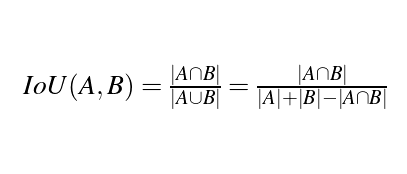

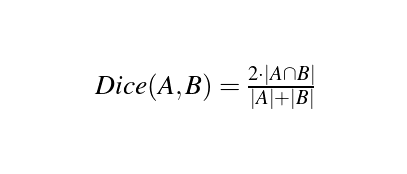

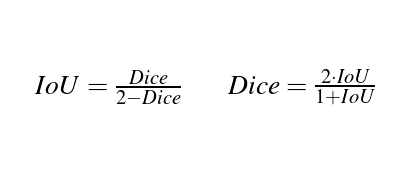

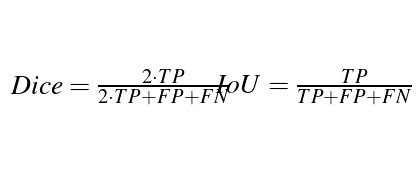

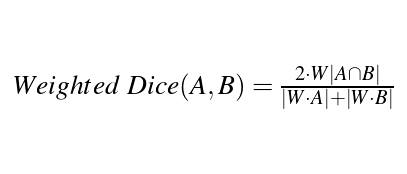

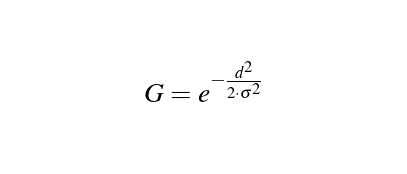

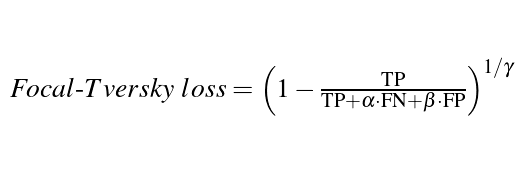

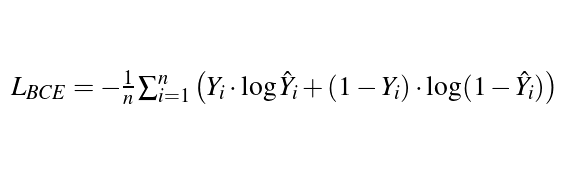

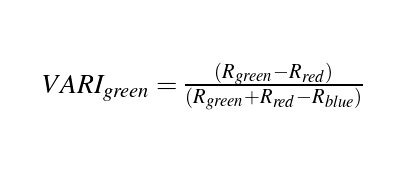

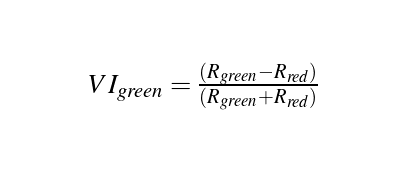

In [32]:
eqs = [
    ('../figures/eq_iou.png',r"$IoU(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}$"),
    ('../figures/eq_dice.png',r"$Dice(A, B) = \frac{2\cdot|A \cap B|}{|A| + |B|}$"),
    ('../figures/eq_iou_dice.png',[r"$IoU = \frac{Dice}{2 - Dice}$", r"$Dice = \frac{2 \cdot IoU}{1 + IoU}$"]),
    ('../figures/eq_iou_dice_cm.png',[r'$Dice = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}$',r'$IoU = \frac{TP}{TP + FP + FN}$']),
    ('../figures/eq_w_dice.png',r"$Weighted \text{ } Dice(A, B) = \frac{2 \cdot W|A \cap B|}{|W \cdot A| + |W \cdot B|}$"),
    ('../figures/eq_gauss.png',r"$G = e^{-\frac{d^2}{2 \cdot \sigma^2}}$"),
    ('../figures/eq_focal-tversky-loss.png',r"$Focal\text{-}Tversky\text{ }loss = \left(1 - \frac{\text{TP}}{\text{TP} + \alpha \cdot \text{FN} + \beta \cdot \text{FP}}\right)^{1/\gamma}$"),
    ('../figures/eq_bce-loss.png',r"$L_{BCE} = -\frac{1}{n} \sum_{i=1}^{n} \left( Y_i \cdot \log \hat{Y}_i + (1 - Y_i) \cdot \log (1 - \hat{Y}_i) \right)$"),
    ('../figures/eq_vari.png',r"$VARI_{green} = \frac{(R_{green} - R_{red})}{(R_{green} + R_{red} - R_{blue})}$"),
    ('../figures/eq_ndvi.png',r"$VI_{green} = \frac{(R_{green} - R_{red})}{(R_{green} + R_{red})}$")
]

for eq in eqs:
    output_path, eq = eq
    if isinstance(eq, list):
        d_eq_2_img(
            eq1=eq[0],
            eq2=eq[1],
            output_path=output_path
        )
    else:
        eq_2_img(
            eq=eq,
            output_path=output_path
        )

### Middle split

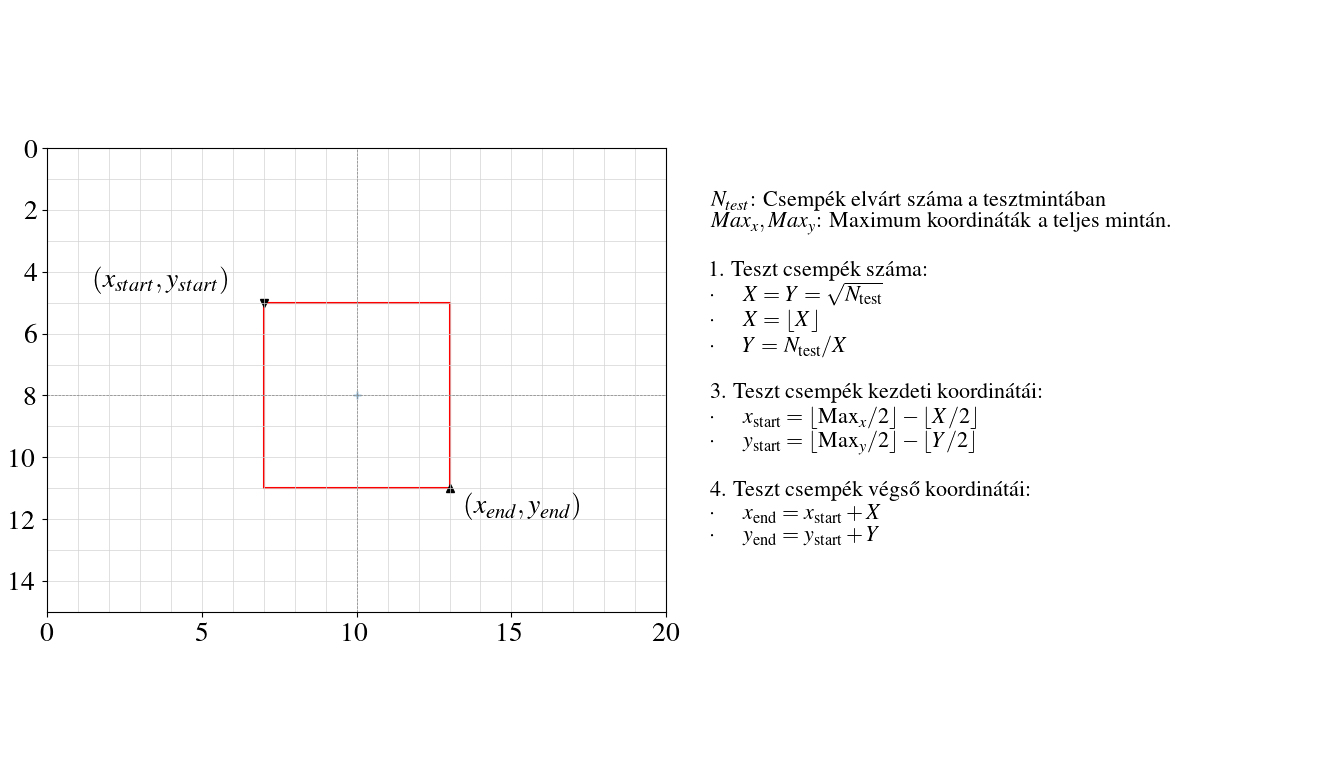

In [2]:
import matplotlib.pyplot as plt
import numpy as np

total_images = 100
train_size = 0.64
test_images_count = int(total_images * (1 - train_size))
X = Y = np.sqrt(test_images_count)

max_x, max_y = 20, 15
mid_x = max_x // 2
mid_y = max_y // 2

x_start = mid_x - int(X // 2)
y_start = mid_y - int(Y // 2)
x_end = x_start + int(X)
y_end = y_start + int(Y)

# Create a figure for illustration with corrected placement
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
#fig, axs = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'width_ratios': [3, 1]})
ax = axs[0]
# Correct the position of the test region to match (x_start, y_start) at the top-left corner
test_rect = plt.Rectangle((x_start, max_y - y_start - Y), X, Y, edgecolor='red', facecolor='none', lw=1.5, label="Test Region")
ax.add_patch(test_rect)

# Annotate corrected key points
ax.plot(x_start, max_y - y_start - Y, 'v', label="Start Point (Top Left)", color = 'black')
ax.text(x_start - 5.5, max_y - y_start - Y - 0.5, r"$(x_{start}, y_{start})$", color="black")
ax.plot(x_end, max_y - y_end + Y, '^', label="End Point (Bottom Right)", color = 'black')
ax.text(x_end + 0.5, max_y - y_end + Y + 0.8, r"$(x_{end}, y_{end})$", color="black")
ax.plot(mid_x, max_y - mid_y, '+', label="Midpoint")
#ax.text(mid_x + 0.5, max_y - mid_y, "(mid_x, mid_y)", color="blue")

# Draw the grid
for i in range(max_x + 1):
    ax.axhline(i, color='lightgray', linewidth=0.5)
    ax.axvline(i, color='lightgray', linewidth=0.5)
    
ax.axhline(mid_y+1, color='gray', linewidth=0.5, linestyle="--")
ax.axvline(mid_x, color='gray', linewidth=0.5, linestyle="--")
        

# Settings for the plot
ax.set_xlim(0, max_x)
ax.set_ylim(max_y, 0)  # Invert Y-axis
ax.set_aspect('equal')
#ax.set_title("Illustration of Test Region in Middle Split (Corrected Placement)", fontsize=14)
#ax.set_xlabel("X-axis (grid width)")
#ax.set_ylabel("Y-axis (grid height)")
#ax.legend(loc="upper right")

# Display the figure
#plt.tight_layout()
#plt.show()

#1. Test Image Count: $N_{\text{test}} = \lfloor N \cdot (1 - T_s) \rfloor$
#$mid_{\text{x}} = $
#$mid_{\text{y}} = $

#Adjust Grid Dimensions (if \(X\) or \(Y\) is a float):
#    Ha$ \text{ } Max_x > Max_y :$
#    $X = \lfloor X \rfloor, \quad Y = \frac{N_{\text{test}}}{X}$
#    
#    Ha$ \text{ } Max_x < Max_y :$
#    $\quad X = \frac{N_{\text{test}}}{Y}, Y = \lfloor X \rfloor$
#    
#    Ha$ \text{ } Max_x = Max_y :$
#    $X = \lfloor X \rfloor, \quad Y = \frac{N_{\text{test}}}{X}$

equations = r"""

$N_{test}$: Csempék elvárt száma a tesztmintában
$Max_x,Max_y$: Maximum koordináták a teljes mintán.

1. Teszt csempék száma: 
   $\cdot \text{  } \quad X = Y = \sqrt{N_{\text{test}}}$
   $\cdot \text{  } \quad X = \lfloor X \rfloor$  
   $\cdot \text{  } \quad Y = N_{\text{test}}/{X}$

3. Teszt csempék kezdeti koordinátái:
   $\cdot \text{  } \quad x_{\text{start}} = \lfloor \text{Max}_x / 2 \rfloor - \lfloor X / 2 \rfloor$
   $\cdot \text{  } \quad y_{\text{start}} = \lfloor \text{Max}_y / 2 \rfloor - \lfloor Y / 2 \rfloor$

4. Teszt csempék végső koordinátái:
   $\cdot \text{  } \quad x_{\text{end}} = x_{\text{start}} + X$
   $\cdot \text{  } \quad y_{\text{end}} = y_{\text{start}} + Y$


"""

axs[1].axis("off")  # Turn off axis for the equations
axs[1].text(0, 0.5, equations, fontsize=16, ha="left", va="center")

# Adjust layout and display
plt.tight_layout()
plt.savefig('../figures/middle_split.png', bbox_inches='tight', dpi=600)
plt.show()




### Weighted map

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


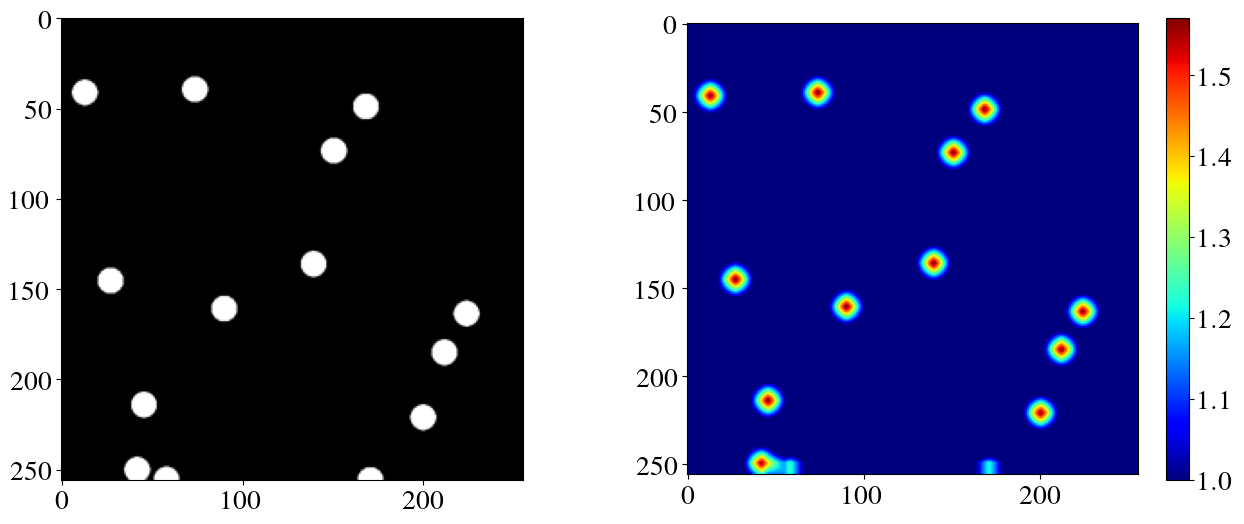

In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

# Load the mask from a PNG file
image_path = "../figures/tile_shp_14_10.png"  # Replace with the actual file path
mask_image = Image.open(image_path).convert("L")  # Convert to grayscale

# Resize the image to 256x256 if it's not already
mask_image = mask_image.resize((256, 256))
mask_array = np.array(mask_image, dtype=np.float32)  
# Convert the image to a PyTorch tensor and normalize the values to [0, 1]
mask = torch.tensor(mask_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

print(mask.size())

weit = 1 + F.avg_pool2d(mask, kernel_size=13, stride=1, padding=6) / 255.0
weit = torch.where(weit < 1.2, torch.tensor(1.0, dtype=weit.dtype, device=weit.device), weit/1.2)
print(weit.size())
# Convert tensors to numpy for visualization
mask_np = mask[0, 0].numpy()
weit_np = weit[0, 0].numpy()

# Plot the original mask and the weight map
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
#plt.title("Original Mask")
plt.imshow(mask_np, cmap='gray')

plt.subplot(1, 2, 2)
#plt.title("Weight Map")
plt.imshow(weit_np, cmap='jet')
plt.colorbar()

plt.savefig('../figures/weight_map.png', bbox_inches='tight', dpi=600)

plt.show()


### px.w. vs. obj.w. cl. metrics

Note: you may need to restart the kernel to use updated packages.


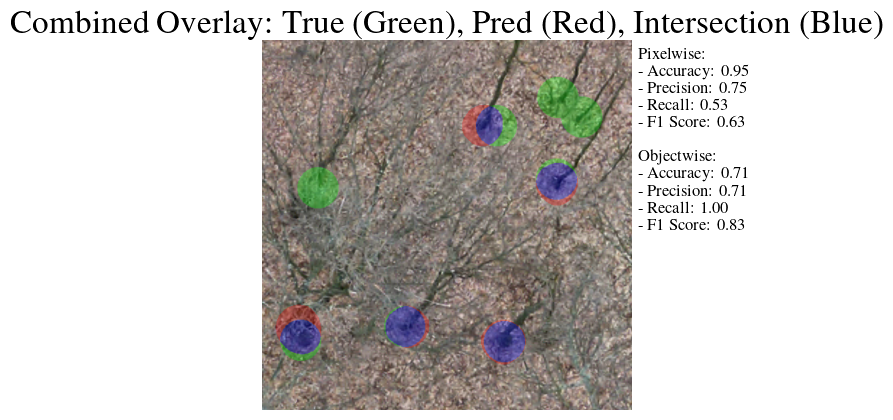

In [16]:
%pip install opencv-python
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2
from models.utils.scores import objectwise_classification_metrics
from PIL import Image

mask_true = (torch.tensor(np.array(cv2.cvtColor(np.array(Image.open('../figures/media_mask_true_512.png')), cv2.COLOR_RGB2GRAY))).unsqueeze(0) == 255).int()
mask_pred = torch.tensor(np.array(cv2.cvtColor(np.array(Image.open('../figures/media_mask_pred_512.png')), cv2.COLOR_RGB2GRAY)==255)).unsqueeze(0).int()

#pixelwise
px_accuracy = accuracy_score(mask_true.flatten(), mask_pred.flatten())
px_precision = precision_score(mask_true.flatten(), mask_pred.flatten(), zero_division=0)
px_recall = recall_score(mask_true.flatten(), mask_pred.flatten(), zero_division=0)
px_f1 = f1_score(mask_true.flatten(), mask_pred.flatten(), zero_division=0)

results = objectwise_classification_metrics(
    mask_true,
    mask_pred,
    threshold = 0.5,
    weighted=True
)

#objectwise
ob_accuracy = accuracy_score(results['ground_truth'],results['predictions']['label'])
ob_precision = precision_score(results['ground_truth'],results['predictions']['label'], zero_division=0)
ob_recall = recall_score(results['ground_truth'],results['predictions']['label'], zero_division=0)
ob_f1 = f1_score(results['ground_truth'],results['predictions']['label'], zero_division=0)

combined_overlay = overlay_combined_mask(
    np.rot90(np.array(Image.open('../figures/media_image_512.png'))[:, :, :3]),
    np.rot90((cv2.cvtColor(np.array(Image.open('../figures/media_mask_true_512.png')), cv2.COLOR_RGB2GRAY)==255).astype(int)),
    np.rot90((cv2.cvtColor(np.array(Image.open('../figures/media_mask_pred_512.png')), cv2.COLOR_RGB2GRAY)==255).astype(int))
)
plt.imshow(combined_overlay)

plt.text(
    520, 285,  # Coordinates in the plot
    f"""
Pixelwise:
    - Accuracy: {px_accuracy:.2f}
    - Precision: {px_precision:.2f}
    - Recall: {px_recall:.2f}
    - F1 Score: {px_f1:.2f}
    
Objectwise:
    - Accuracy: {ob_accuracy:.2f}
    - Precision: {ob_precision:.2f}
    - Recall: {ob_recall:.2f}
    - F1 Score: {ob_f1:.2f}
    """,
    fontsize=12,
    color='black',
    bbox=dict(facecolor='white', alpha=0.0)
)
plt.title('Combined Overlay: True (Green), Pred (Red), Intersection (Blue)')
plt.axis('off')
plt.savefig('../figures/weight_map.png', bbox_inches='tight', dpi=600)
plt.show()

### others

[(0.0, 0.5, 0.4, 1.0),
 (0.10980392156862745, 0.5549019607843138, 0.4, 1.0),
 (0.2196078431372549, 0.6098039215686275, 0.4, 1.0),
 (0.3333333333333333, 0.6666666666666666, 0.4, 1.0),
 (0.44313725490196076, 0.7215686274509804, 0.4, 1.0),
 (0.5568627450980392, 0.7784313725490196, 0.4, 1.0),
 (0.6666666666666666, 0.8333333333333333, 0.4, 1.0),
 (0.7803921568627451, 0.8901960784313725, 0.4, 1.0),
 (0.8901960784313725, 0.9450980392156862, 0.4, 1.0),
 (1.0, 1.0, 0.4, 1.0)]

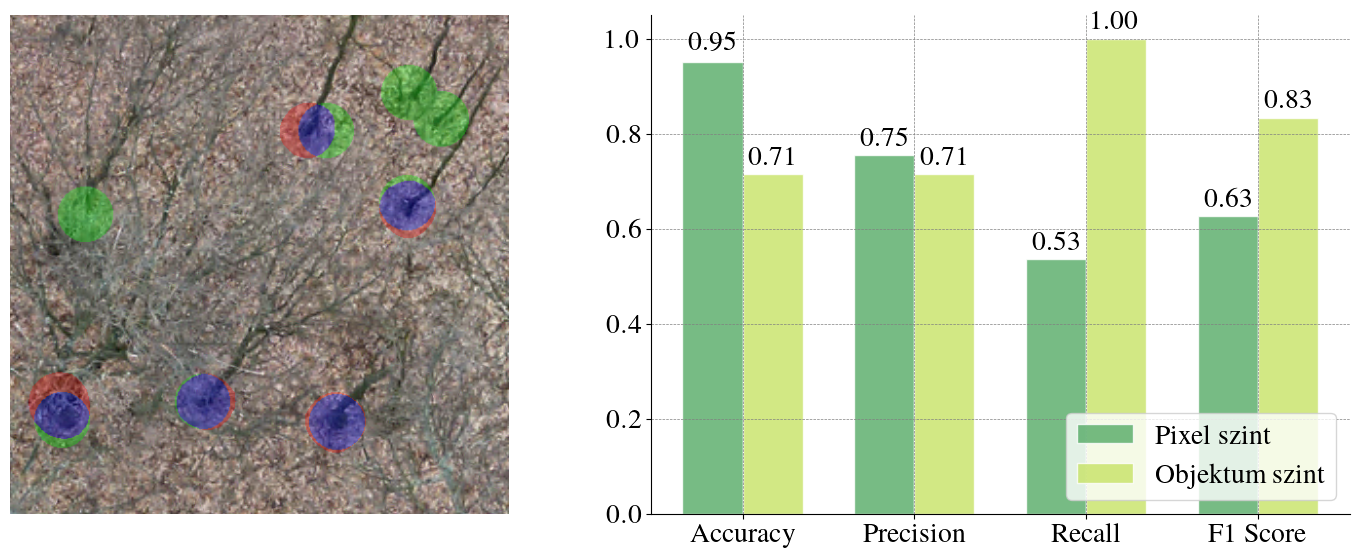

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
pixelwise_metrics = [px_accuracy, px_precision, px_recall, px_f1]
objectwise_metrics = [ob_accuracy, ob_precision, ob_recall, ob_f1]

# Bar positions
x = np.arange(len(metrics_names))  # Label locations
width = 0.35  # Width of the bars

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Subplot 1: Combined overlay
axes[0].imshow(combined_overlay)
#axes[0].set_title('Combined Overlay: True (Green), Pred (Red), Intersection (Blue)')
axes[0].axis('off')

# Subplot 2: Metrics bar plot
# Bars for Pixelwise and Objectwise metrics
bar1 = axes[1].bar(x - width/2, pixelwise_metrics, width, label='Pixel szint', alpha=0.8, color=s_color_values[3], edgecolor='white')
bar2 = axes[1].bar(x + width/2, objectwise_metrics, width, label='Objektum szint', alpha=0.8, color=s_color_values[-3], edgecolor='white')

# Customize the bar plot
#axes[1].set_ylabel('Score')
#axes[1].set_title('Pixelwise vs Objectwise Metrics')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names)
axes[1].legend(loc='lower right')

# Add value annotations on bars
def add_annotations(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset for the text
                    textcoords="offset points",
                    ha='center', va='bottom')

add_annotations(bar1, axes[1])
add_annotations(bar2, axes[1])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout and save the figure
plt.tight_layout()
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
plt.savefig('../figures/metrics_and_overlay.png', bbox_inches='tight', dpi=600)
plt.show()


### reconversion

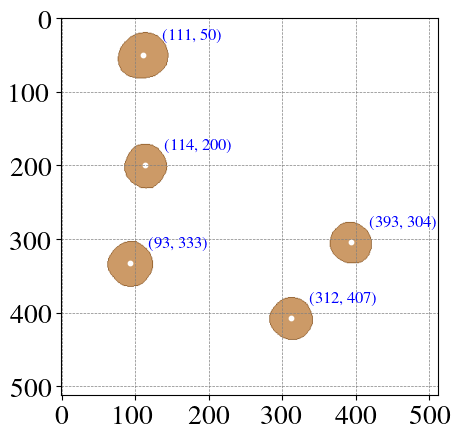

[(312, 407), (93, 333), (393, 304), (114, 200), (111, 50)]

In [102]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def mask_to_image(mask: np.ndarray, mask_values):
    """
    Converts a mask to a PIL image using specified mask values.
    """
    if isinstance(mask_values[0], list):
        out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
    elif mask_values == [0, 1]:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
    else:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

    if mask.ndim == 3:
        mask = np.argmax(mask, axis=0)

    for i, v in enumerate(mask_values):
        out[mask == i] = v

    return Image.fromarray(out)

def getPoints_fromPNG(img):
    """
    Processes an image to find contours, centroids, and plots the results.
    """
    # Convert image to RGB for consistent plotting
    out_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    ## 1. Original Image
    #plt.figure(figsize=(15, 10))
    #plt.subplot(2, 3, 1)
    #plt.imshow(out_img)
    #plt.title('Original Image')
    #plt.axis('off')
#
    ## 2. Convert to Grayscale
    img_gray = img  # Since the input is already grayscale
    #plt.subplot(2, 3, 2)
    #plt.imshow(img_gray, cmap='gray')
    #plt.title('Grayscale Image')
    #plt.axis('off')
#
    ## 3. Thresholding to get Binary Image
    _, img_binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
    #plt.subplot(2, 3, 3)
    #plt.imshow(img_binary, cmap='gray')
    #plt.title('Binary Image')
    #plt.axis('off')
#
    ## 4. Find Contours
    contours, _ = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a copy of the image to draw contours
    img_contours = img_gray.copy()
    cv2.drawContours(out_img, contours, -1, list(int(component * 255) for component in color_values[2][:3]), 1)  # Draw contours in green
    #plt.subplot(2, 3, 4)
    #plt.imshow(out_img)
    #plt.title('Contours')
    #plt.axis('off')

    # 5. Calculate centroids and mark them
    white_dot_centers = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            white_dot_centers.append((cX, cY))
            #cv2.circle(out_img, (cX, cY), 2, (255, 0, 0), -1)  # Draw centroids in red

    # Set the background to white
    # Plot the image with contours and centroids
    #plt.subplot(2, 3, 5)
    green_color = np.array(list(int(component * 255) for component in b_color_values[6][:3]))  # Green color in RGB
    opacity = 0.99  # Define your opacity level (0 to 1)
    
    # Create a mask for white pixels
    white_mask = np.all(out_img == [255, 255, 255], axis=-1)
    out_img[white_mask] = (1 - opacity) * out_img[white_mask] + opacity * green_color
    
    out_img[np.all(out_img == [0, 0, 0], axis=-1)] = [255, 255, 255]
    plt.imshow(out_img)
    
    # Mark the centroids and label them
    for (x, y) in white_dot_centers:
        plt.scatter(x, y, color='white', marker='o', s=10)  # Mark the center
        plt.text(x + 25, y - 20, f'({x}, {y})', color='blue', fontsize=12)
    
    # Add grid and custom ticks
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    ticks = np.arange(0, 513, 100)
    plt.xticks(ticks)
    plt.yticks(ticks)
    # Invert y-axis to start from bottom
    #plt.gca().invert_yaxis()

    #plt.title('Contours with Centroids and Grid')
    plt.axis('on')

    plt.tight_layout()
    plt.savefig('../figures/reconversion_loc.png', bbox_inches='tight', dpi=600)
    
    plt.show()

    return white_dot_centers

#pil_image = mask_to_image(
#    mask=mod_mask,  # Replace `mod_mask` with your actual mask data
#    mask_values=[0, 255]
#)
pil_image = Image.open(f'../figures/media_mask_pred_512.png').convert('L')

image_array = np.array(pil_image)

#image_array = image_array[:, :, :3]

# Convert to OpenCV image (if not already)
if len(image_array.shape) == 3 and image_array.shape[2] == 3:  # Check if the image has 3 channels
    cv2_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
else:
    cv2_image = image_array 

getPoints_fromPNG(cv2_image)


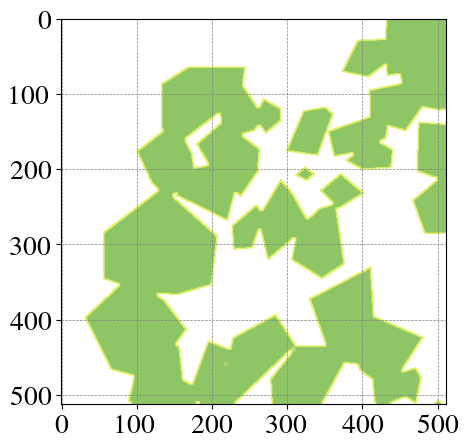

In [97]:
from PIL import Image, ImageDraw
radius=50
image_path = '../data/2024-11-13-seg-dataset-2048/aug_train/masks/tile_75.png'
mask_path = 'media_image_seg2_mask.png'
mask_path = '../figures/media_image_seg_2048_3_mask.png'
image_path ='media_image_seg.png'

center_x=256
center_y=256
with Image.open(mask_path) as img:
    img = img.convert("L")  # Convert to grayscale
    width, height = img.size
    pixels = np.array(img)
    
    # Create a new image with a white background
    white_background = Image.new("RGB", (width, height), "white")
    white_pixels = (pixels == 255).astype(np.uint8)  # Detect white pixels (polygon area)

    o_white_pixels =[]
    # Draw the edges of the polygon in green
    green_polygon = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(green_polygon)
    for y in range(height):
        for x in range(width):
            if white_pixels[y, x]:
                # Check 8-neighborhood to see if it is an edge pixel
                #green_polygon.putpixel((x, y), (200, 255, 200))
                green_polygon.putpixel((x, y), tuple(int(component * 255) for component in s_color_values[-5][:3]))
                if any(not white_pixels[ny, nx] for nx, ny in [(x-2, y), (x+2, y), (x, y-2), (x, y+2),
                                                               (x-2, y-2), (x+2, y-2), (x-2, y+2), (x+2, y+2)]
                       if 0 <= nx < width and 0 <= ny < height):
                    green_polygon.putpixel((x, y), tuple(int(component * 255) for component in s_color_values[-2][:3]))  # Mark edge as green
                
fig, ax = plt.subplots(figsize=(5, 5))

# Add grid
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)


# Set ticks
ticks = np.arange(0, 513, 100)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Display the updated image
ax.imshow(green_polygon)

# Set axis visibility
ax.axis("on")
plt.savefig('../figures/reconversion_seg.png', bbox_inches='tight', dpi=600)

# Show the figure
plt.show()


### loc exp. figures

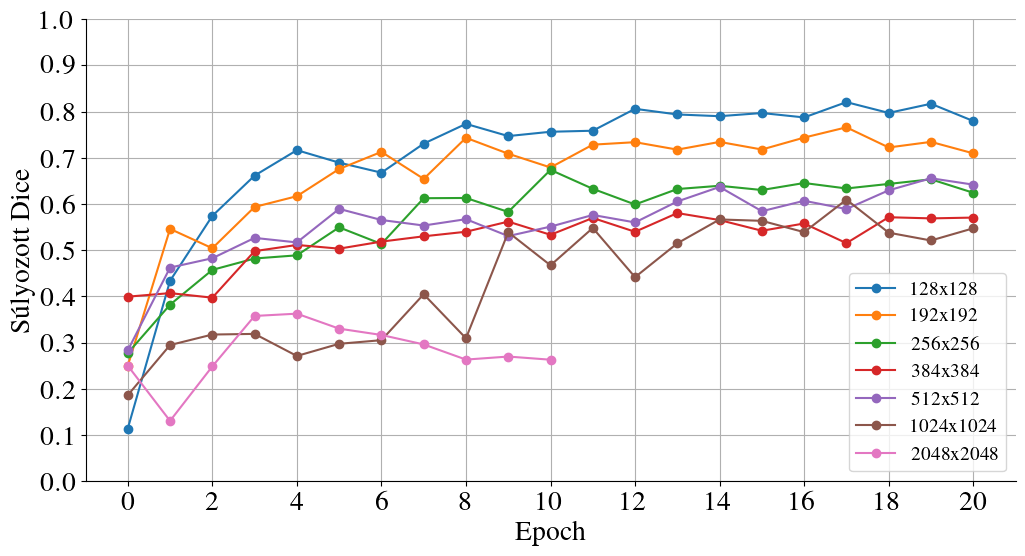

In [65]:
sizes = [128,192,256,384,512,1024,2048]
cols = [f'unet-biomed-{size} - Segmentation metrics.Weighted Dice' for size in sizes]
rename_mapping = {col: f'{size}x{size}' for col, size in zip(cols, sizes)}

df = pd.read_csv('../figures/wandb_exports/1-wdice_wandb_export_2024-12-06T13_11_54.473+01_00.csv')[cols].rename(columns=rename_mapping)

plt.figure(figsize=(12, 6))
for column in df.columns:
    plt.plot(df.index[:21], df[column][:21], label=column, marker='o')

plt.yticks(ticks=np.arange(0, 1.01, 0.1))
plt.xticks(ticks=np.arange(0, 21, 2))
#plt.title('Súlyozott Dice - UNet Biomed')
plt.xlabel('Epoch')
plt.ylabel('Súlyozott Dice')
plt.legend(fontsize=14, loc='lower right')

plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/1_loc_w_d_score.png', bbox_inches='tight', dpi=600)
plt.show()

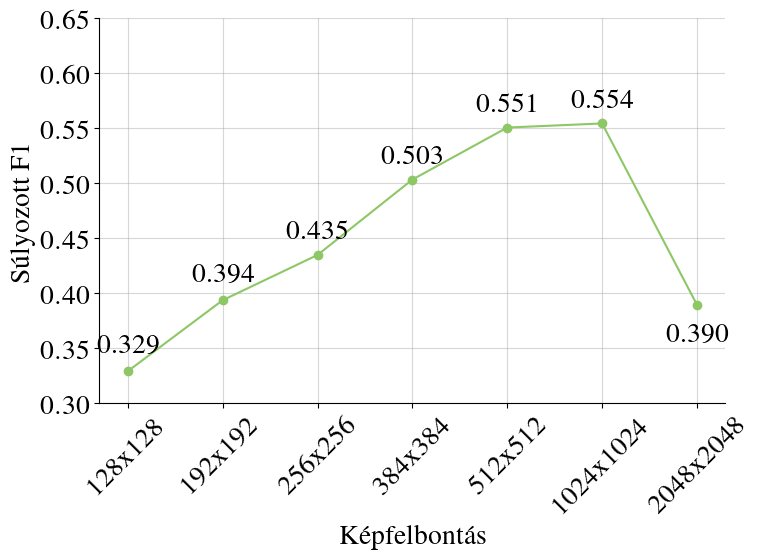

In [146]:
sizes = [128,192,256,384,512,1024,2048]
cols = [f'test_biomed_{size}_aug10 - Classification metrics.Weighted F1-score 50' for size in sizes]
rename_mapping = {col: f'{size}x{size}' for col, size in zip(cols, sizes)}

df = pd.read_csv('../figures/wandb_exports/1-wmf1_wandb_export_2024-12-06T13_35_36.341+01_00.csv')[cols].rename(columns=rename_mapping)
df = df.transpose().reset_index().rename(columns={'index':'Resolution',0:'Weighted F1-score'})

plt.figure(figsize=(8, 6))
plt.plot(df['Resolution'], df['Weighted F1-score'], label='Weighted F1-score',
         marker='o', linestyle='-', color=s_color_values[5])

for x, y in zip(df['Resolution'][:-1], df['Weighted F1-score'][:-1]):
    plt.text(x, y+0.01, f'{y:.3f}', ha='center', va='bottom')
plt.text(df['Resolution'][len(df)-1], df['Weighted F1-score'][len(df)-1]-0.04, f"{df['Weighted F1-score'][len(df)-1]:.3f}", ha='center', va='bottom')
    
#plt.title('Súlyozott F1 - UNet Biomed')
plt.ylabel('Súlyozott F1')
plt.xlabel('Képfelbontás')
plt.grid(True,alpha=0.5)
plt.xticks(rotation=45)
plt.yticks(ticks=np.arange(0.3, 0.7, 0.05))
#plt.yticks(ticks=np.arange(0.0, 1.1, 0.1))
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/1_loc_f1_score.png', bbox_inches='tight', dpi=600)
plt.show()


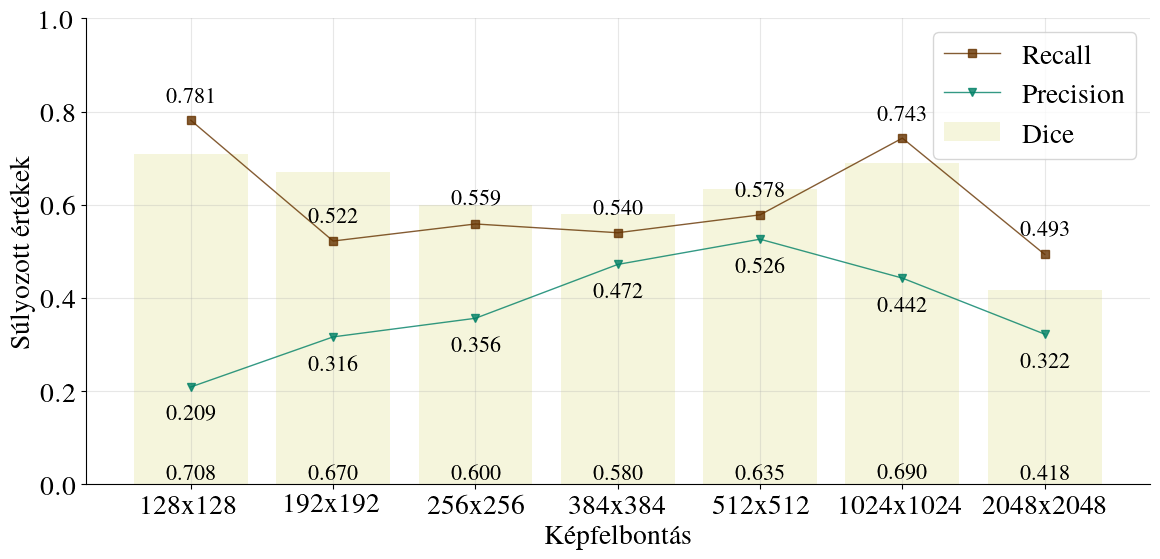

In [139]:
sizes = [128,192,256,384,512,1024,2048]
cols = [f'test_biomed_{size}_aug10 - Classification metrics.Weighted Recall 50' for size in sizes]
rename_mapping = {col: f'{size}x{size}' for col, size in zip(cols, sizes)}
df = pd.read_csv('../figures/wandb_exports/1-rec_wandb_export_2024-12-06T13_59_40.162+01_00.csv')[cols].rename(columns=rename_mapping)
df_rec = df.transpose().reset_index().rename(columns={0:'Weighted Recall'})

cols = [f'test_biomed_{size}_aug10 - Classification metrics.Weighted Precision 50' for size in sizes]
rename_mapping = {col: f'{size}x{size}' for col, size in zip(cols, sizes)}
df = pd.read_csv('../figures/wandb_exports/1-prec_wandb_export_2024-12-06T13_59_22.838+01_00.csv')[cols].rename(columns=rename_mapping)
df_prec = df.transpose().reset_index().rename(columns={0:'Weighted Precision'})

cols = [f'test_biomed_{size}_aug10 - Segmentation metrics.Weighted Dice' for size in sizes]
rename_mapping = {col: f'{size}x{size}' for col, size in zip(cols, sizes)}
df = pd.read_csv('../figures/wandb_exports/1-seg_wandb_export_2024-12-06T18_05_57.897+01_00.csv')[cols].rename(columns=rename_mapping)
df_dice = df.transpose().reset_index().rename(columns={0:'Weighted Dice'})

df_combined = pd.merge(df_rec, df_prec, on='index')
df_combined = pd.merge(df_combined, df_dice, on='index')

# Plotting
plt.figure(figsize=(12, 6))

# Recall plot
plt.plot(df_combined['index'], df_combined['Weighted Recall'], label='Recall',
         marker='s', linestyle='-', color=b_color_values[0], linewidth=1, alpha=0.8)

# Precision plot
plt.plot(df_combined['index'], df_combined['Weighted Precision'], label='Precision',
         marker='v', linestyle='-', color=s_color_values[0], linewidth=1, alpha=0.8)

plt.bar(df_combined['index'], df_combined['Weighted Dice'], label='Dice', color='beige', alpha=1)

# Adding values above the markers
for x, y in zip(df_combined['index'], df_combined['Weighted Recall']):
    plt.text(x, y+0.03, f'{y:.3f}', ha='center', va='bottom', fontsize=16)
for x, y in zip(df_combined['index'], df_combined['Weighted Precision']):
    plt.text(x, y-0.08, f'{y:.3f}', ha='center', va='bottom', fontsize=16)
for x, y in zip(df_combined['index'], df_combined['Weighted Dice']):
    plt.text(x, 0, f'{y:.3f}', ha='center', va='bottom', fontsize=16)

#plt.title('Weighted Recall and Precision by Resolution')
plt.ylabel('Súlyozott értékek')
plt.xlabel('Képfelbontás')
plt.grid(True, alpha=0.3)
#plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(ticks=np.arange(0.0, 1.1, 0.2))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../figures/1_loc_p_r_score.png', bbox_inches='tight', dpi=600)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('1-conf_wandb_export_2024-12-06T18_24_30.198+01_00.csv')
# Extract unique models and labels
models = df['name'].unique()
labels = ['background', 'tree']

# Initialize the data for bar plots
confusion_data = {label: {label_pred: [] for label_pred in labels} for label in labels}

# Populate the data for bar plots
for actual in labels:
    for predicted in labels:
        values = [df[(df['Actual'] == actual) & (df['Predicted'] == predicted) & (df['name'] == model)]['nPredictions'].sum()
                  for model in models]
        confusion_data[actual][predicted] = values

# Plot the bar chart confusion matrix
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, actual in enumerate(labels):
    for j, predicted in enumerate(labels):
        ax = axes[i * 2 + j]
        bar_container = ax.bar(models, confusion_data[actual][predicted], color=plt.cm.tab20.colors, edgecolor='black')
        
        # Annotate values on the bars
        for bar, value in zip(bar_container, confusion_data[actual][predicted]):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(value)}',
                    ha='center', va='bottom', fontsize=8)
        
        ax.set_title(f'{actual} -> {predicted}', fontsize=10)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

ax.legend()
fig.suptitle('Confusion Matrix with Model Contributions and Values', fontsize=14, y=0.92)
fig.text(0.5, 0.04, 'Models', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Number of Predictions', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.92])
plt.show()



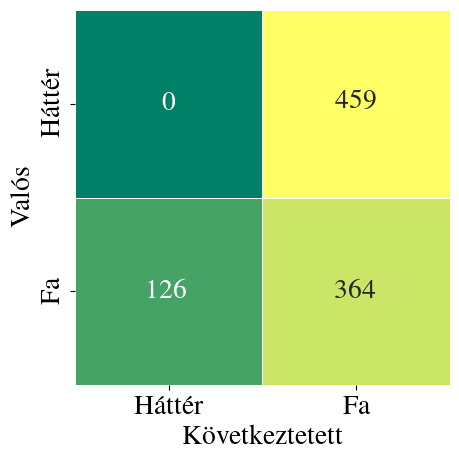

In [9]:
df = pd.read_csv('../figures/wandb_exports/1-conf_wandb_export_2024-12-06T18_24_30.198+01_00.csv')
df = df[df['name']=='test_biomed_1024_aug10']

translation_map = {
    "background": "Háttér",
    "tree": "Fa"
}
df["Valós"] = df["Actual"].map(translation_map)
df["Következtett"] = df["Predicted"].map(translation_map)

confusion_matrix = df.pivot_table(index="Következtett", columns="Valós", values="nPredictions", aggfunc="sum", fill_value=0)
confusion_matrix = df.pivot_table(index="Valós", columns="Következtett", values="nPredictions", aggfunc="sum", fill_value=0)

# Plotting the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix.iloc[::-1, ::-1], annot=True, fmt="d", cmap='summer', linewidths=0.5, cbar=False)

#plt.title("Confusion Matrix")
plt.xlabel("Következtetett")
plt.ylabel("Valós")
plt.tight_layout()
plt.savefig('../figures/1_loc_cm.png', bbox_inches='tight', dpi=600)

plt.show()


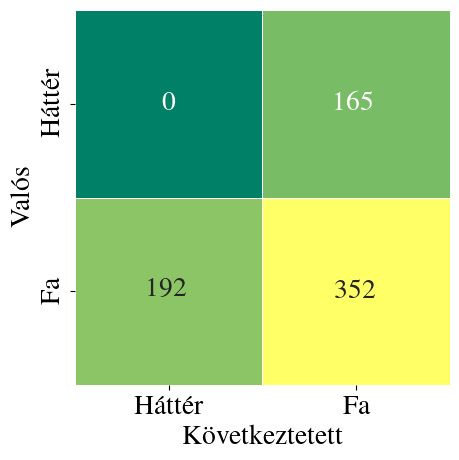

In [10]:
df = pd.read_csv('../figures/wandb_exports/4-loc-yolo-cm_wandb_export_2024-12-15T01_13_55.944+01_00.csv')
df = df[df['name']=='test_yolo_512']

translation_map = {
    "background": "Háttér",
    "tree": "Fa"
}
df["Valós"] = df["Actual"].map(translation_map)
df["Következtett"] = df["Predicted"].map(translation_map)

confusion_matrix = df.pivot_table(index="Következtett", columns="Valós", values="nPredictions", aggfunc="sum", fill_value=0)
confusion_matrix = df.pivot_table(index="Valós", columns="Következtett", values="nPredictions", aggfunc="sum", fill_value=0)

# Plotting the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix.iloc[::-1, ::-1], annot=True, fmt="d", cmap='summer', linewidths=0.5, cbar=False)

#plt.title("Confusion Matrix")
plt.xlabel("Következtetett")
plt.ylabel("Valós")
plt.tight_layout()
plt.savefig('../figures/4_loc_cm.png', bbox_inches='tight', dpi=600)

plt.show()

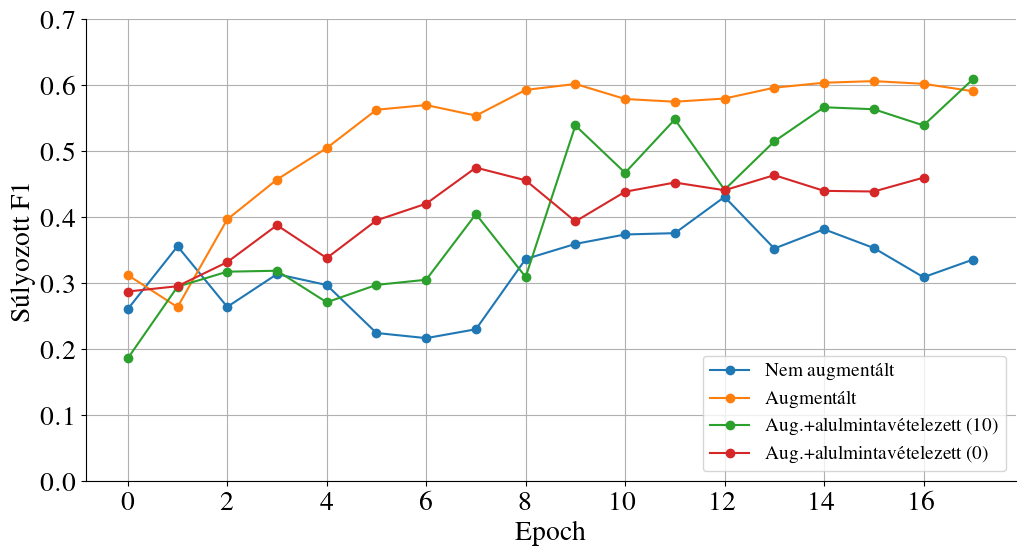

In [15]:
names = ['1024_noaug','1024_aug50','1024','1024_aug0']
correct_names = [
    'Nem augmentált', # 49 minutes
    'Augmentált', # 2 hours 45 minutes
    'Aug.+alulmintavételezett (10)', # 2 hours 38 minutes
    'Aug.+alulmintavételezett (0)' # 2 hours 4 minutes
]
times = ['49 perc', '2 óra 45 perc', '2 óra 38 perc', '2 óra 4 perc']

cols = [f'unet-biomed-{name} - Segmentation metrics.Weighted Dice' for name in names]
rename_mapping = {col: name for col, name in zip(cols, correct_names)}

df = pd.read_csv('../figures/wandb_exports/2-loc-dice-1024_wandb_export_2024-12-10T12_28_24.658+01_00.csv')[cols].rename(columns=rename_mapping)

plt.figure(figsize=(12, 6))
for column, time in zip(df.columns, times):
    plt.plot(df.index[:18], df[column][:18], label=column, marker='o')
    #if str(df[column][17])=='nan':
    #    plt.annotate(
    #        time,
    #        (df.index[16]+0.1, df[column].iloc[15]),  # Coordinates of the last point
    #        textcoords="offset points",
    #        xytext=(10, 0),  # Offset for the annotation
    #        ha='left',
    #        color='gray',  # Gray text
    #    )
    #else:
    #    plt.annotate(
    #        time,
    #        (df.index[17]+0.1, df[column].iloc[15]),  # Coordinates of the last point
    #        textcoords="offset points",
    #        xytext=(10, 0),  # Offset for the annotation
    #        ha='left',
    #        color='gray',  # Gray text
    #    )
        

plt.yticks(ticks=np.arange(0, 0.8, 0.1))
#plt.xticks(ticks=np.arange(0, 24, 2))
plt.xticks(ticks=np.arange(0, 18, 2))
#plt.title('Súlyozott Dice - UNet Biomed')
plt.xlabel('Epoch')
plt.ylabel('Súlyozott F1')
plt.legend(fontsize=14, loc='lower right')

plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/2_loc_w_d_score.png', bbox_inches='tight', dpi=600)
plt.show()

              index  Weighted F1 Score  Weighted Dice
0    Nem augmentált           0.482143       0.516066
1        Augmentált           0.548454       0.550926
2  Aug.+alulm. (10)           0.554455       0.690377
3   Aug.+alulm. (0)           0.499438       0.483324


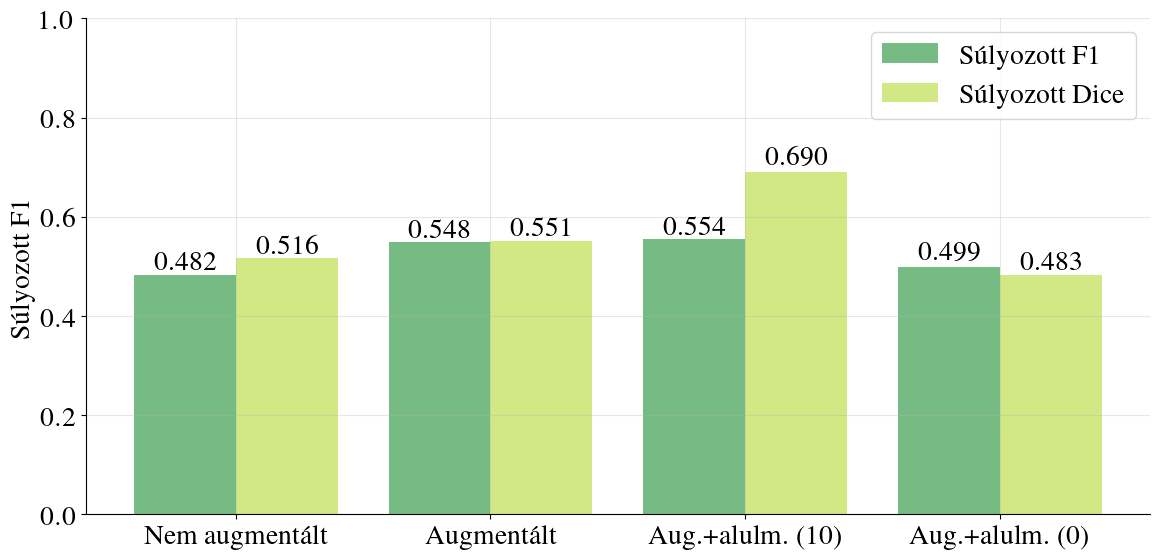

In [13]:
names = ['1024_noaug','1024_aug50','1024_aug10','1024_aug0']
correct_names = [
    'Nem augmentált', 
    'Augmentált',
    'Aug.+alulm. (10)', 
    'Aug.+alulm. (0)' 
]
times = ['49 perc', '2 óra 45 perc', '2 óra 38 perc', '2 óra 4 perc']

cols1 = [f'test_biomed_{name} - Classification metrics.Weighted F1-score 50' for name in names]
cols2 = [f'test_biomed_{name} - Segmentation metrics.Weighted Dice' for name in names]

rename_mapping = {col: name for col, name in zip(cols1, correct_names)}

df_combined = pd.read_csv('../figures/wandb_exports/2-loc-wmf1-1024_wandb_export_2024-12-10T12_04_16.288+01_00.csv')[cols1].rename(columns=rename_mapping)
df_combined = df_combined.transpose().reset_index().rename(columns={0:'Weighted F1 Score'})

rename_mapping = {col: name for col, name in zip(cols2, correct_names)}

df_combined1 = pd.read_csv('../figures/wandb_exports/2-loc-wdice_wandb_export_2024-12-13T23_19_34.433+01_00.csv')[cols2].rename(columns=rename_mapping)
df_combined1 = df_combined1.transpose().reset_index().rename(columns={0:'Weighted Dice'})
df_combined['Weighted Dice'] = df_combined1['Weighted Dice']

x = np.arange(len(df_combined))  # x positions for groups
# Plotting
plt.figure(figsize=(12, 6))
#
#plt.bar(df_combined['index'], df_combined['Weighted F1 Score'], label='Weighted F1 Score', color=s_color_values[3], alpha=1)
#
#for x, y in zip(df_combined['index'], df_combined['Weighted F1 Score']):
#    plt.text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=16)
#
# Plot F1 Score bars

print(df_combined)
width = 0.4  # Bar width
plt.bar(x - width/2, df_combined['Weighted F1 Score'], width, label='Súlyozott F1', color=s_color_values[3], alpha=0.8)

# Plot Dice Score bars
plt.bar(x + width/2, df_combined['Weighted Dice'], width, label='Súlyozott Dice', color=s_color_values[-3], alpha=0.8)

# Add text for F1 bars
for i, (f1, dice) in enumerate(zip(df_combined['Weighted F1 Score'], df_combined['Weighted Dice'])):
    plt.text(x[i] - width/2, f1, f'{f1:.3f}', ha='center', va='bottom')
    plt.text(x[i] + width/2, dice, f'{dice:.3f}', ha='center', va='bottom')

#plt.title('Weighted Recall and Precision by Resolution')
plt.ylabel('Súlyozott F1')
plt.xticks(x, df_combined['index'])
#plt.xlabel('Képfelbontás')
plt.grid(True, alpha=0.3)
#plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(ticks=np.arange(0.0, 1.1, 0.2))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../figures/2_loc_test_score.png', bbox_inches='tight', dpi=600)
plt.show()


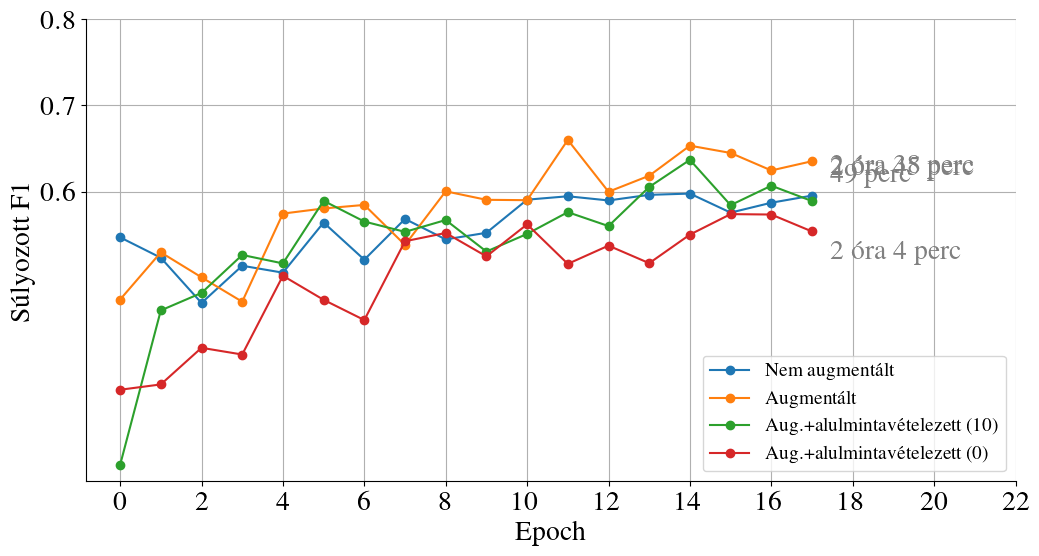

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

names = ['legacy_unet-biomed-512-no_aug_2', 'legacy_unet-biomed-512-aug_50_2', 'unet-biomed-512', 'legacy_unet-biomed-512_aug100']
correct_names = [
    'Nem augmentált',  # 49 minutes
    'Augmentált',  # 2 hours 45 minutes
    'Aug.+alulmintavételezett (10)',  # 2 hours 38 minutes
    'Aug.+alulmintavételezett (0)'  # 2 hours 4 minutes
]
times = ['49 perc', '2 óra 45 perc', '2 óra 38 perc', '2 óra 4 perc']

cols = [f'{name} - Segmentation metrics.Weighted Dice' for name in names]
rename_mapping = {col: name for col, name in zip(cols, correct_names)}

# Load the CSV file
df = pd.read_csv('../figures/wandb_exports/2-loc-dice-512_wandb_export_2024-12-10T12_24_56.001+01_00.csv')[cols].rename(columns=rename_mapping)

plt.figure(figsize=(12, 6))

# Dynamic vertical offset for each annotation
y_offsets = [10, -10, 20, -20]  # Adjust offsets as needed

for idx, (column, time) in enumerate(zip(df.columns, times)):
    plt.plot(df.index[:18], df[column][:18], label=column, marker='o')
    if str(df[column][17]) == 'nan':
        plt.annotate(
            time,
            (df.index[16] + 0.1, df[column].iloc[15]),  # Coordinates of the last point
            textcoords="offset points",
            xytext=(10, y_offsets[idx % len(y_offsets)]),  # Offset for the annotation
            ha='left',
            color='gray',  # Gray text
        )
    else:
        plt.annotate(
            time,
            (df.index[17] + 0.1, df[column].iloc[17]),  # Coordinates of the last point
            textcoords="offset points",
            xytext=(10, y_offsets[idx % len(y_offsets)]),  # Offset for the annotation
            ha='left',
            color='gray',  # Gray text
        )

plt.yticks(ticks=np.arange(0.6, 0.8, 0.1))
plt.xticks(ticks=np.arange(0, 24, 2))
# plt.title('Súlyozott Dice - UNet Biomed')
plt.xlabel('Epoch')
plt.ylabel('Súlyozott F1')
plt.legend(fontsize=14, loc='lower right')

plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/2_loc_w_d_512_score.png', bbox_inches='tight', dpi=600)
plt.show()


In [97]:
names = ['legacy_unet-biomed-512-no_aug_2', 'legacy_unet-biomed-512-aug_50_2', 'unet-biomed-512', 'legacy_unet-biomed-512_aug100']
correct_names = [
    'Nem augmentált',  # 49 minutes
    'Augmentált',  # 2 hours 45 minutes
    'Aug.+alulmintavételezett (10)',  # 2 hours 38 minutes
    'Aug.+alulmintavételezett (0)'  # 2 hours 4 minutes
]
times = ['49 perc', '2 óra 45 perc', '2 óra 38 perc', '2 óra 4 perc']

cols = [f'test_biomed_{name} - Classification metrics.Weighted F1-score 50' for name in names]
rename_mapping = {col: name for col, name in zip(cols, correct_names)}

df_combined = pd.read_csv('../figures/wandb_exports/2-loc-wmf1-512_wandb_export_2024-12-10T12_25_24.114+01_00.csv')[cols].rename(columns=rename_mapping)
df_combined = df_combined.transpose().reset_index().rename(columns={0:'Weighted F1 Score'})
# Plotting
plt.figure(figsize=(12, 6))

plt.bar(df_combined['index'], df_combined['Weighted F1 Score'], label='Weighted F1 Score', color='beige', alpha=1)

for x, y in zip(df_combined['index'], df_combined['Weighted F1 Score']):
    plt.text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=16)

#plt.title('Weighted Recall and Precision by Resolution')
plt.ylabel('Súlyozott értékek')
plt.xlabel('Képfelbontás')
plt.grid(True, alpha=0.3)
#plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(ticks=np.arange(0.0, 1.1, 0.2))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../figures/2_loc_wf1_score.png', bbox_inches='tight', dpi=600)
plt.show()


KeyError: "None of [Index(['test_biomed_legacy_unet-biomed-512-no_aug_2 - Classification metrics.Weighted F1-score 50',\n       'test_biomed_legacy_unet-biomed-512-aug_50_2 - Classification metrics.Weighted F1-score 50',\n       'test_biomed_unet-biomed-512 - Classification metrics.Weighted F1-score 50',\n       'test_biomed_legacy_unet-biomed-512_aug100 - Classification metrics.Weighted F1-score 50'],\n      dtype='object')] are in the [columns]"

### loc 3.exp.

Note: you may need to restart the kernel to use updated packages.


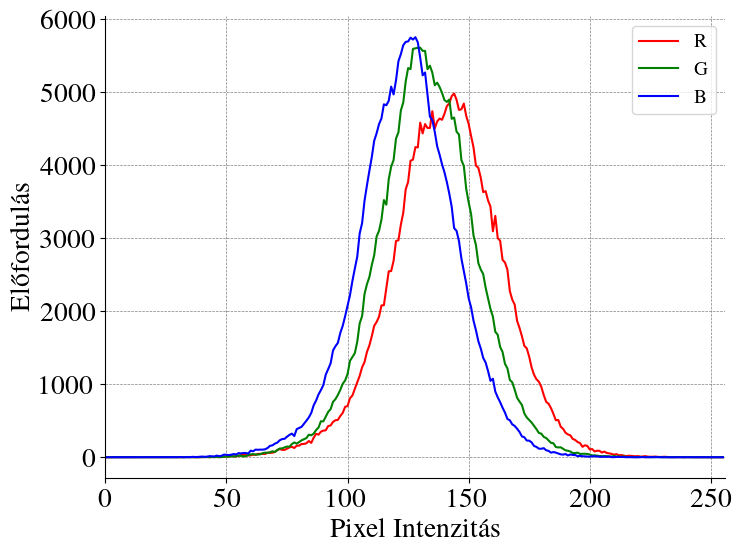

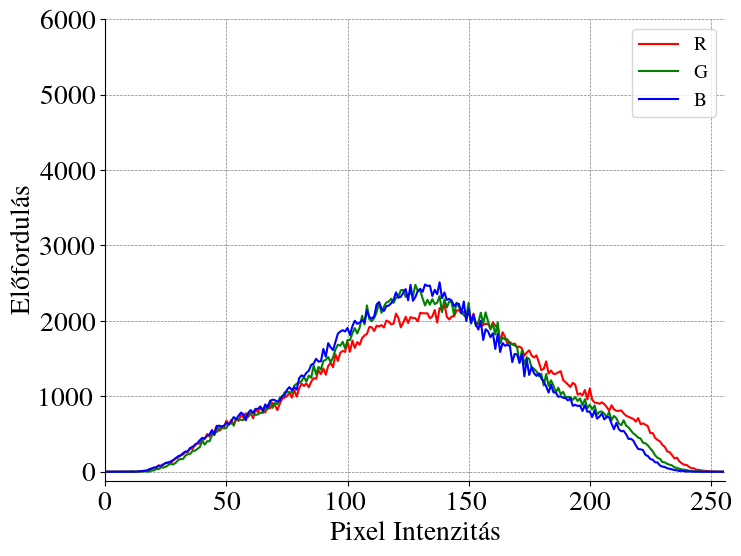

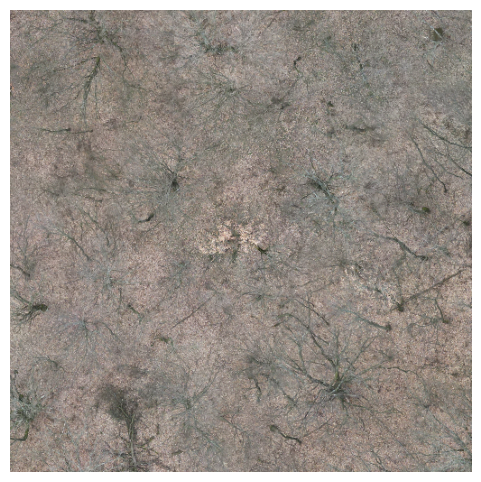

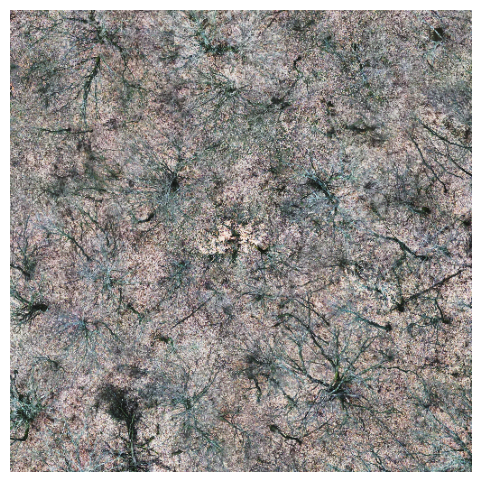

In [106]:
%pip install opencv-python
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load an RGB image
image_path = './tile_135.png'
image = cv2.imread(image_path)

# Check if the image was loaded correctly
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Convert the image from BGR to RGB for visualization
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply CLAHE to each channel separately
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized_channels = [clahe.apply(image_rgb[:, :, i]) for i in range(3)]
equalized_image = cv2.merge(equalized_channels)

# Calculate histograms for each channel
original_histograms = [cv2.calcHist([image_rgb[:, :, i]], [0], None, [256], [0, 256]) for i in range(3)]
equalized_histograms = [cv2.calcHist([equalized_image[:, :, i]], [0], None, [256], [0, 256]) for i in range(3)]

# Colors and channel names
colors = ['red', 'green', 'blue']
channel_names = ['R', 'G', 'B']

# Plot the merged histograms for the original image
plt.figure(figsize=(8, 6))
#plt.title('Original Histograms - RGB Channels')
for i, color in enumerate(colors):
    plt.plot(original_histograms[i], color=color, label=f'{channel_names[i]}')
plt.xlim([0, 256])
plt.yticks(ticks=np.arange(0, 6001, 1000))
plt.xlabel('Pixel Intenzitás')
plt.ylabel('Előfordulás')
plt.legend(fontsize=14, loc='upper right')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
plt.savefig('../figures/3_loc_h1_score.png', bbox_inches='tight', dpi=600)
plt.show()

# Plot the merged histograms for the equalized image
plt.figure(figsize=(8, 6))
#plt.title('Equalized Histograms - RGB Channels')
for i, color in enumerate(colors):
    plt.plot(equalized_histograms[i], color=color, label=f'{channel_names[i]}')
plt.xlim([0, 256])
plt.yticks(ticks=np.arange(0, 6001, 1000))
plt.xlabel('Pixel Intenzitás')
plt.ylabel('Előfordulás')
plt.legend(fontsize=14, loc='upper right')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
plt.savefig('../figures/3_loc_h2_score.png', bbox_inches='tight', dpi=600)
plt.show()

# Display the original image
plt.figure(figsize=(6, 6))
#plt.title('Original RGB Image')
plt.imshow(image_rgb)
plt.axis('off')
plt.savefig('../figures/3_loc_img_score.png', bbox_inches='tight', dpi=600)
plt.show()

# Display the equalized image
plt.figure(figsize=(6, 6))
#plt.title('Equalized RGB Image')
plt.imshow(equalized_image)
plt.axis('off')
plt.savefig('../figures/3_loc_clahe_score.png', bbox_inches='tight', dpi=600)
plt.show()


Index(['Step',
       'test_biomed_1024 - Classification metrics.Weighted F1-score 50',
       'test_biomed_1024 - Classification metrics.Weighted F1-score 50__MIN',
       'test_biomed_1024 - Classification metrics.Weighted F1-score 50__MAX',
       'test_biomed_1024_aug10 - Classification metrics.Weighted F1-score 50',
       'test_biomed_1024_aug10 - Classification metrics.Weighted F1-score 50__MIN',
       'test_biomed_1024_aug10 - Classification metrics.Weighted F1-score 50__MAX'],
      dtype='object')


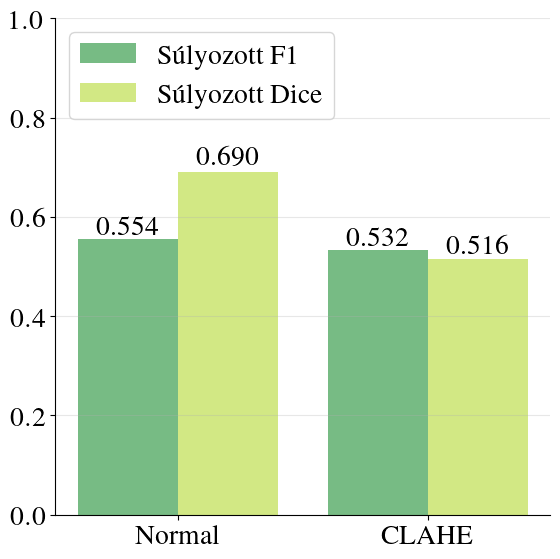

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(pd.read_csv('../figures/wandb_exports/3-loc-wf1-test_wandb_export_2024-12-13T11_44_45.418+01_00.csv').columns)

# Correct Names
correct_names = [
    'Normal',
    'CLAHE'
]

# Column names for Weighted F1 and Weighted Dice
cols1 = [
    'test_biomed_1024_aug10 - Classification metrics.Weighted F1-score 50',
    'test_biomed_1024 - Classification metrics.Weighted F1-score 50'
]

cols2 = [
    'test_biomed_1024_aug10 - Segmentation metrics.Weighted Dice',
    'test_biomed_1024 - Segmentation metrics.Weighted Dice'
]

# Rename Mapping
rename_mapping = {col: name for col, name in zip(cols1, correct_names)}

# Read and process df1 for F1 Score
df1 = (
    pd.read_csv('../figures/wandb_exports/3-loc-wf1-test_wandb_export_2024-12-13T11_44_45.418+01_00.csv')[cols1]
    .rename(columns=rename_mapping)
    .transpose()
    .reset_index()
    .rename(columns={0: 'Weighted F1 Score'})
)

# Read and process df2 for Dice Score
rename_mapping = {col: name for col, name in zip(cols2, correct_names)}
df2 = (
    pd.read_csv('../figures/wandb_exports/3-loc-wdice-test_wandb_export_2024-12-13T11_44_26.792+01_00.csv')[cols2]
    .rename(columns=rename_mapping)
    .transpose()
    .reset_index()
    .rename(columns={0: 'Weighted Dice'})
)


# Merge the two dataframes for side-by-side plotting
df1['Weighted Dice'] = df2['Weighted Dice']

# Plotting
x = np.arange(len(df1))  # x positions for groups
width = 0.4  # Bar width

plt.figure(figsize=(6, 6))

# Plot F1 Score bars
plt.bar(x - width/2, df1['Weighted F1 Score'], width, label='Súlyozott F1', color=s_color_values[3], alpha=0.8)

# Plot Dice Score bars
plt.bar(x + width/2, df1['Weighted Dice'], width, label='Súlyozott Dice', color=s_color_values[-3], alpha=0.8)

# Add text for F1 bars
for i, (f1, dice) in enumerate(zip(df1['Weighted F1 Score'], df1['Weighted Dice'])):
    plt.text(x[i] - width/2, f1, f'{f1:.3f}', ha='center', va='bottom')
    plt.text(x[i] + width/2, dice, f'{dice:.3f}', ha='center', va='bottom')

# Formatting
#plt.ylabel('Scores')
plt.xticks(x, df1['index'])
plt.yticks(ticks=np.arange(0.0, 1.1, 0.2))
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

# Save and show the plot
plt.savefig('../figures/3-loc-test.png', bbox_inches='tight', dpi=600)
plt.show()


Index(['epoch', 'loc-unet-centroid-1024 - _step',
       'loc-unet-centroid-1024 - _step__MIN',
       'loc-unet-centroid-1024 - _step__MAX',
       'loc-unet-centroid-1024 - Segmentation metrics.Weighted Dice',
       'loc-unet-centroid-1024 - Segmentation metrics.Weighted Dice__MIN',
       'loc-unet-centroid-1024 - Segmentation metrics.Weighted Dice__MAX',
       'taunet-1024-sota - _step', 'taunet-1024-sota - _step__MIN',
       'taunet-1024-sota - _step__MAX',
       'taunet-1024-sota - Segmentation metrics.Weighted Dice',
       'taunet-1024-sota - Segmentation metrics.Weighted Dice__MIN',
       'taunet-1024-sota - Segmentation metrics.Weighted Dice__MAX',
       'ds_transunet_base_512_u10_NEW-large_patch - _step',
       'ds_transunet_base_512_u10_NEW-large_patch - _step__MIN',
       'ds_transunet_base_512_u10_NEW-large_patch - _step__MAX',
       'ds_transunet_base_512_u10_NEW-large_patch - Segmentation metrics.Weighted Dice',
       'ds_transunet_base_512_u10_NEW-large_patch

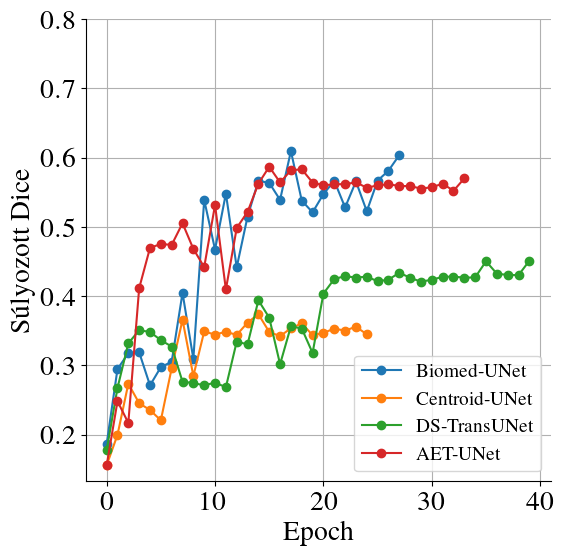

In [57]:
print(pd.read_csv('../figures/wandb_exports/4-loc-wdice_wandb_export_2024-12-13T12_07_32.300+01_00.csv').columns)

cols = [
    'unet-biomed-1024 - Segmentation metrics.Weighted Dice',
    'loc-unet-centroid-1024 - Segmentation metrics.Weighted Dice',
    'ds_transunet_base_512_u10_NEW-large_patch - Segmentation metrics.Weighted Dice',
    'taunet-1024-sota - Segmentation metrics.Weighted Dice',
]
correct_names = [
    'Biomed-UNet',
    'Centroid-UNet',
    'DS-TransUNet',
    'AET-UNet',
    #'YOLOv11-seg',
]


rename_mapping = {col: name for col, name in zip(cols, correct_names)}
df = pd.read_csv('../figures/wandb_exports/4-loc-wdice_wandb_export_2024-12-13T12_07_32.300+01_00.csv')[cols].rename(columns=rename_mapping)
print(df)
plt.figure(figsize=(6, 6))
for column in df.columns:
    plt.plot(df.index[:40], df[column][:40], label=column, marker='o')

plt.yticks(ticks=np.arange(0.2, 0.81, 0.1))
#plt.title('Súlyozott Dice - UNet Biomed')
plt.xlabel('Epoch')
plt.ylabel('Súlyozott Dice')
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/4_seg_dice_score.png', bbox_inches='tight', dpi=600)
plt.show()

Index(['epoch', 'loc-unet-centroid-1024 - _step',
       'loc-unet-centroid-1024 - _step__MIN',
       'loc-unet-centroid-1024 - _step__MAX',
       'loc-unet-centroid-1024 - Classification metrics.Weighted F1-score 50',
       'loc-unet-centroid-1024 - Classification metrics.Weighted F1-score 50__MIN',
       'loc-unet-centroid-1024 - Classification metrics.Weighted F1-score 50__MAX',
       'taunet-1024-sota - _step', 'taunet-1024-sota - _step__MIN',
       'taunet-1024-sota - _step__MAX',
       'taunet-1024-sota - Classification metrics.Weighted F1-score 50',
       'taunet-1024-sota - Classification metrics.Weighted F1-score 50__MIN',
       'taunet-1024-sota - Classification metrics.Weighted F1-score 50__MAX',
       'ds_transunet_base_512_u10_NEW-large_patch - _step',
       'ds_transunet_base_512_u10_NEW-large_patch - _step__MIN',
       'ds_transunet_base_512_u10_NEW-large_patch - _step__MAX',
       'ds_transunet_base_512_u10_NEW-large_patch - Classification metrics.Weighted 

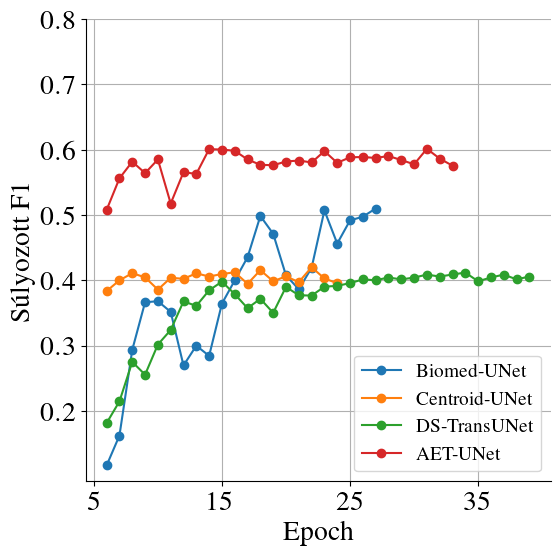

In [62]:
print(pd.read_csv('../figures/wandb_exports/4-loc-wf1_wandb_export_2024-12-13T11_58_42.224+01_00.csv').columns)

cols = [
    'unet-biomed-1024 - Classification metrics.Weighted F1-score 50',
    'loc-unet-centroid-1024 - Classification metrics.Weighted F1-score 50',
    'ds_transunet_base_512_u10_NEW-large_patch - Classification metrics.Weighted F1-score 50',
    'taunet-1024-sota - Classification metrics.Weighted F1-score 50',
]
correct_names = [
    'Biomed-UNet',
    'Centroid-UNet',
    'DS-TransUNet',
    'AET-UNet',
    #'YOLOv11-seg',
]


rename_mapping = {col: name for col, name in zip(cols, correct_names)}
df = pd.read_csv('../figures/wandb_exports/4-loc-wf1_wandb_export_2024-12-13T11_58_42.224+01_00.csv')[cols].rename(columns=rename_mapping)
df = df.replace(0, None)
print(df)
plt.figure(figsize=(6, 6))
for column in df.columns:
    plt.plot(df.index[:40], df[column][:40], label=column, marker='o')

plt.yticks(ticks=np.arange(0.2, 0.81, 0.1))
plt.xticks(ticks=np.arange(5, 41, 10))
#plt.title('Súlyozott Dice - UNet Biomed')
plt.xlabel('Epoch')
plt.ylabel('Súlyozott F1')
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/4_seg_wf1_score.png', bbox_inches='tight', dpi=600)
plt.show()

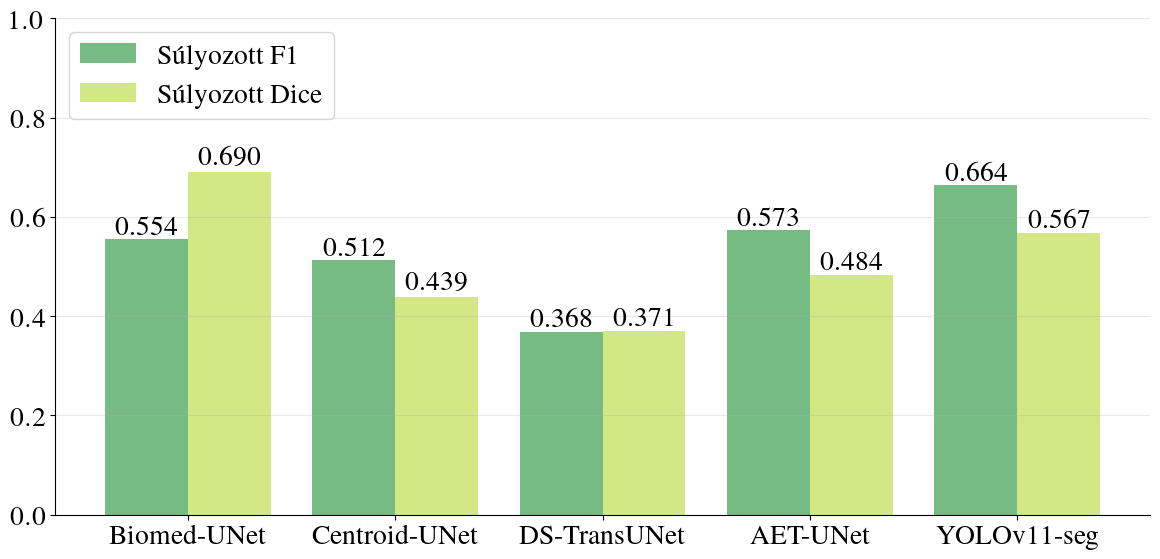

In [8]:
pd.read_csv('../figures/wandb_exports/04-loc_test_wandb_export_2024-12-11T12_33_29.090+01_00.csv')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Correct Names
correct_names = [
    'Biomed-UNet',
    'Centroid-UNet',
    'DS-TransUNet',
    'AET-UNet',
    'YOLOv11-seg',
]

# Column names for Weighted F1 and Weighted Dice
cols1 = [
    'test_biomed_1024_aug10 - Classification metrics.Weighted F1-score 50',
    'test_centroid_loc_1024 - Classification metrics.Weighted F1-score 50',
    'ds_transunet_base_512_u10_NEW-large_patch - Classification metrics.Weighted F1-score 50',
    'test_taunet_1024 - Classification metrics.Weighted F1-score 50',
    'test_yolo_512 - Classification metrics.Weighted F1-score 50',
]

cols2 = [
    'test_biomed_1024_aug10 - Segmentation metrics.Weighted Dice',
    'test_centroid_loc_1024 - Segmentation metrics.Weighted Dice',
    'ds_transunet_base_512_u10_NEW-large_patch - Segmentation metrics.Weighted Dice',
    'test_taunet_1024 - Segmentation metrics.Weighted Dice',
    'test_yolo_512 - Segmentation metrics.Weighted Dice',
]

# Rename Mapping
rename_mapping = {col: name for col, name in zip(cols1, correct_names)}

# Read and process df1 for F1 Score
df1 = (
    pd.read_csv('../figures/wandb_exports/04-loc_test_wandb_export_2024-12-11T12_33_29.090+01_00.csv')[cols1]
    .rename(columns=rename_mapping)
    .transpose()
    .reset_index()
    .rename(columns={0: 'Weighted F1 Score'})
)

# Read and process df2 for Dice Score
rename_mapping = {col: name for col, name in zip(cols2, correct_names)}
df2 = (
    pd.read_csv('../figures/wandb_exports/04-loc-dice-test_wandb_export_2024-12-11T12_34_29.646+01_00.csv')[cols2]
    .rename(columns=rename_mapping)
    .transpose()
    .reset_index()
    .rename(columns={0: 'Weighted Dice'})
)


# Merge the two dataframes for side-by-side plotting
df1['Weighted Dice'] = df2['Weighted Dice']

# Plotting
x = np.arange(len(df1))  # x positions for groups
width = 0.4  # Bar width

plt.figure(figsize=(12, 6))

# Plot F1 Score bars
plt.bar(x - width/2, df1['Weighted F1 Score'], width, label='Súlyozott F1', color=s_color_values[3], alpha=0.8)

# Plot Dice Score bars
plt.bar(x + width/2, df1['Weighted Dice'], width, label='Súlyozott Dice', color=s_color_values[-3], alpha=0.8)

# Add text for F1 bars
for i, (f1, dice) in enumerate(zip(df1['Weighted F1 Score'], df1['Weighted Dice'])):
    plt.text(x[i] - width/2, f1, f'{f1:.3f}', ha='center', va='bottom')
    plt.text(x[i] + width/2, dice, f'{dice:.3f}', ha='center', va='bottom')

# Formatting
#plt.ylabel('Scores')
plt.xticks(x, df1['index'])
plt.yticks(ticks=np.arange(0.0, 1.1, 0.2))
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

# Save and show the plot
plt.savefig('../figures/4_loc_wf1_dice_score_side_by_side.png', bbox_inches='tight', dpi=600)
plt.show()


In [ ]:
### loc 4 exp.

### canopy 1

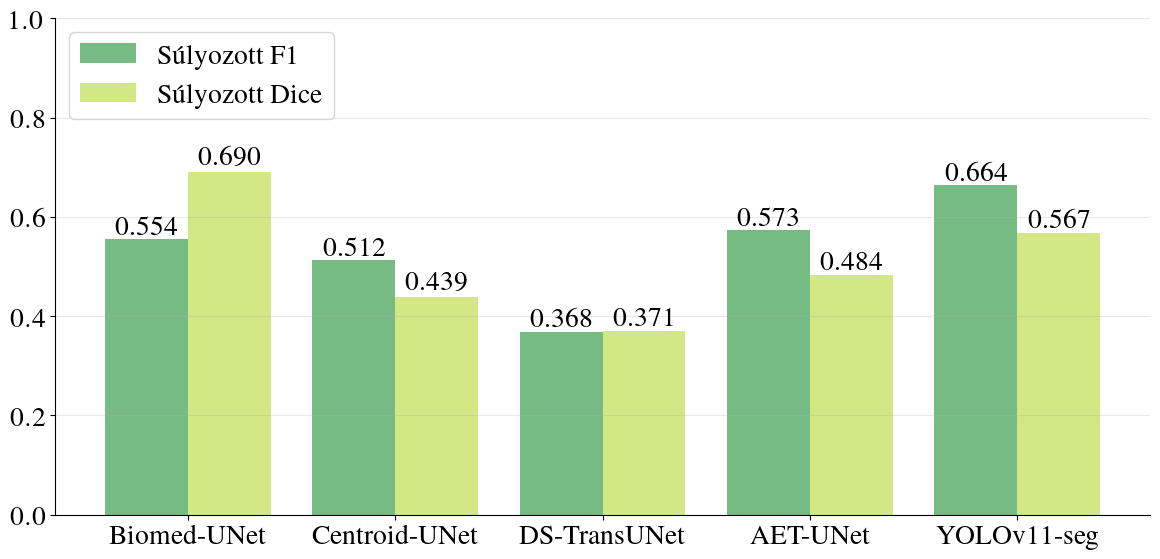

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Correct Names
correct_names = [
    'Biomed-UNet',
    'Centroid-UNet',
    'DS-TransUNet',
    'AET-UNet',
    'YOLOv11-seg',
]

# Column names for Weighted F1 and Weighted Dice
cols1 = [
    'test_biomed_1024_aug10 - Classification metrics.Weighted F1-score 50',
    'test_centroid_loc_1024 - Classification metrics.Weighted F1-score 50',
    'ds_transunet_base_512_u10_NEW-large_patch - Classification metrics.Weighted F1-score 50',
    'test_taunet_1024 - Classification metrics.Weighted F1-score 50',
    'test_yolo_512 - Classification metrics.Weighted F1-score 50',
]

cols2 = [
    'test_biomed_1024_aug10 - Segmentation metrics.Weighted Dice',
    'test_centroid_loc_1024 - Segmentation metrics.Weighted Dice',
    'ds_transunet_base_512_u10_NEW-large_patch - Segmentation metrics.Weighted Dice',
    'test_taunet_1024 - Segmentation metrics.Weighted Dice',
    'test_yolo_512 - Segmentation metrics.Weighted Dice',
]

# Rename Mapping
rename_mapping = {col: name for col, name in zip(cols1, correct_names)}

# Read and process df1 for F1 Score
df1 = (
    pd.read_csv('../figures/wandb_exports/04-loc_test_wandb_export_2024-12-11T12_33_29.090+01_00.csv')[cols1]
    .rename(columns=rename_mapping)
    .transpose()
    .reset_index()
    .rename(columns={0: 'Weighted F1 Score'})
)

# Read and process df2 for Dice Score
rename_mapping = {col: name for col, name in zip(cols2, correct_names)}
df2 = (
    pd.read_csv('../figures/wandb_exports/04-loc-dice-test_wandb_export_2024-12-11T12_34_29.646+01_00.csv')[cols2]
    .rename(columns=rename_mapping)
    .transpose()
    .reset_index()
    .rename(columns={0: 'Weighted Dice'})
)


# Merge the two dataframes for side-by-side plotting
df1['Weighted Dice'] = df2['Weighted Dice']

# Plotting
x = np.arange(len(df1))  # x positions for groups
width = 0.4  # Bar width

plt.figure(figsize=(12, 6))

# Plot F1 Score bars
plt.bar(x - width/2, df1['Weighted F1 Score'], width, label='Súlyozott F1', color=s_color_values[3], alpha=0.8)

# Plot Dice Score bars
plt.bar(x + width/2, df1['Weighted Dice'], width, label='Súlyozott Dice', color=s_color_values[-3], alpha=0.8)

# Add text for F1 bars
for i, (f1, dice) in enumerate(zip(df1['Weighted F1 Score'], df1['Weighted Dice'])):
    plt.text(x[i] - width/2, f1, f'{f1:.3f}', ha='center', va='bottom')
    plt.text(x[i] + width/2, dice, f'{dice:.3f}', ha='center', va='bottom')

# Formatting
#plt.ylabel('Scores')
plt.xticks(x, df1['index'])
plt.yticks(ticks=np.arange(0.0, 1.1, 0.2))
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

# Save and show the plot
plt.savefig('../figures/4_loc_wf1_dice_score_side_by_side.png', bbox_inches='tight', dpi=600)
plt.show()


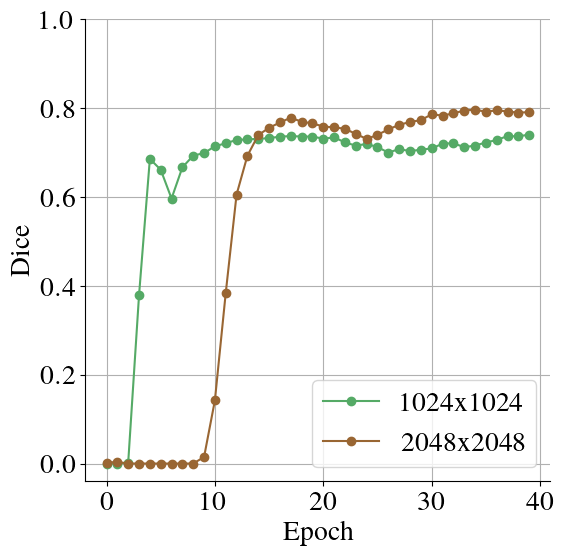

In [32]:
sizes = [1024,2048]
cols = [f'seg-unet-biomed-{size} - Segmentation metrics.Dice' for size in sizes]
rename_mapping = {col: f'{size}x{size}' for col, size in zip(cols, sizes)}

df = pd.read_csv('../figures/wandb_exports/1-seg-dice_wandb_export_2024-12-08T22_15_51.469+01_00.csv')[cols].rename(columns=rename_mapping)

plt.figure(figsize=(6, 6))

plt.plot(df.index[:40], df[df.columns[0]][:40], label=df.columns[0], marker='o', color=s_color_values[3])
plt.plot(df.index[:40], df[df.columns[1]][:40], label=df.columns[1], marker='o', color=b_color_values[3])

plt.yticks(ticks=np.arange(0, 1.01, 0.2))
#plt.title('Súlyozott Dice - UNet Biomed')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend(loc="lower right")
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/1_seg_dice_score.png', bbox_inches='tight', dpi=600)
plt.show()

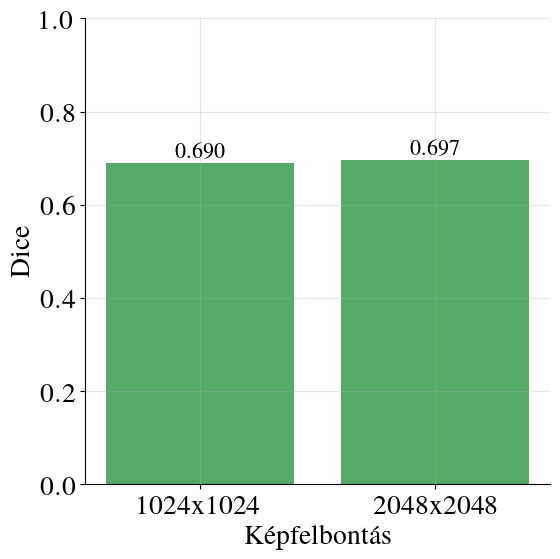

In [18]:
correct_names = [
    '1024x1024',
    '2048x2048',
]

cols = [
    'test_biomed_1024 - Segmentation metrics.Dice',
    'test_biomed_2048-sota - Segmentation metrics.Dice'
]
rename_mapping = {col: name for col, name in zip(cols, correct_names)}

df_combined = pd.read_csv('../figures/wandb_exports/1-seg-dice-test_wandb_export_2024-12-13T10_08_05.286+01_00.csv')[cols].rename(columns=rename_mapping)
df_combined = df_combined.transpose().reset_index().rename(columns={0:'Dice'})
# Plotting
plt.figure(figsize=(6, 6))

plt.bar(df_combined['index'], df_combined['Dice'], label='Dice', color=s_color_values[3], alpha=1)

for x, y in zip(df_combined['index'], df_combined['Dice']):
    plt.text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=16)

#plt.title('Weighted Recall and Precision by Resolution')
plt.ylabel('Dice')
plt.xlabel('Képfelbontás')
plt.grid(True, alpha=0.3)
#plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(ticks=np.arange(0.0, 1.1, 0.2))
#plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../figures/1_seg_dice-test_score.png', bbox_inches='tight', dpi=600)
plt.show()


In [5]:
pd.read_csv('../figures/wandb_exports/1-seg-dice-test_wandb_export_2024-12-13T10_08_05.286+01_00.csv').columns

Index(['Step', 'test_biomed_1024 - Segmentation metrics.Dice',
       'test_biomed_1024 - Segmentation metrics.Dice__MIN',
       'test_biomed_1024 - Segmentation metrics.Dice__MAX',
       'test_biomed_2048-sota - Segmentation metrics.Dice',
       'test_biomed_2048-sota - Segmentation metrics.Dice__MIN',
       'test_biomed_2048-sota - Segmentation metrics.Dice__MAX'],
      dtype='object')

(512, 512)
(512, 512)


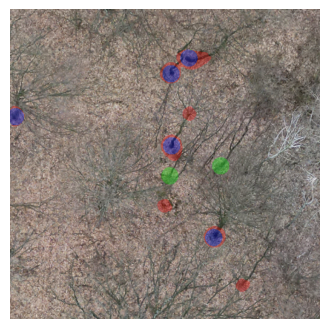

In [49]:
model = UNet.model(UNet.config(n_channels=3, n_classes=1, bilinear=False))
load_model(
    model,
    './legacy/checkpoints_loc-unet-biomed-1024_2024-11-12_13-42_checkpoint_epoch27.pth',#'./legacy/checkpoints_loc-unet-centroid-1024_2024-11-20_11-01_sota_checkpoint_epoch26.pth',
    'cpu'
)

index = '15_14'
index = '23_6'
index = '20_3'
full_img = Image.open(f'../data/2024-10-30-loc-dataset-1024/u_aug_train_u10/images/tile_tif_{index}_180.png')
true_mask = Image.open(f'../data/2024-10-30-loc-dataset-1024/u_aug_train_u10/masks/tile_shp_{index}_180.png')
pred = predict_img(
    net = model,
    full_img = full_img,
    device = 'cpu',
    scale_factor=1,
    out_threshold=0.5
)

print(np.array(true_mask).shape)

mask_true = (torch.tensor(np.array(true_mask)).unsqueeze(0) == 255).int()
mask_pred = torch.tensor(pred).unsqueeze(0)

from models.utils.scores import objectwise_classification_metrics

results = objectwise_classification_metrics(
    mask_pred,
    mask_true,
    threshold = 0.5,
    weighted=False
)
tp_mask = results['tp_mask_batch']
fp_mask = results['fp_mask_batch']
fn_mask = results['fn_mask_batch']

true_mask = np.squeeze(mask_true.squeeze(0).numpy())
pred_mask = np.squeeze(mask_pred.squeeze(0).numpy())
tp_mask = np.squeeze(tp_mask)
fp_mask = np.squeeze(fp_mask)
fn_mask = np.squeeze(fn_mask)
print(true_mask.shape)
target_size = (1024, 1024)
#true_mask = cv2.resize(true_mask, target_size, interpolation=cv2.INTER_NEAREST)
#pred_mask = cv2.resize(pred_mask, target_size, interpolation=cv2.INTER_NEAREST)

true_mask =np.rot90(true_mask)
pred_mask =np.rot90(pred_mask)
plt.figure(figsize=(4, 8))
combined_overlay = overlay_combined_mask(np.rot90(np.array(Image.open(f'../data/2024-10-30-loc-dataset-1024/u_aug_train_u10/images/tile_tif_{index}_180.png'))), true_mask, pred_mask)
plt.imshow(combined_overlay)
#plt.title('Combined Overlay: True (Green), Pred (Red), Intersection (Blue)')
plt.axis('off')
plt.show()

findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not

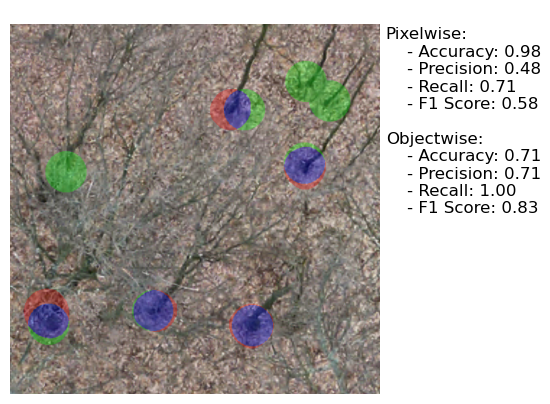

In [19]:
mask_pred.shape

torch.Size([1, 512, 512])

In [51]:
mod_mask = mask_pred[0].long().squeeze().numpy()

# Convert to uint8 if necessary
if mod_mask.dtype != np.uint8:
    mod_mask = mod_mask.astype(np.uint8)

findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not

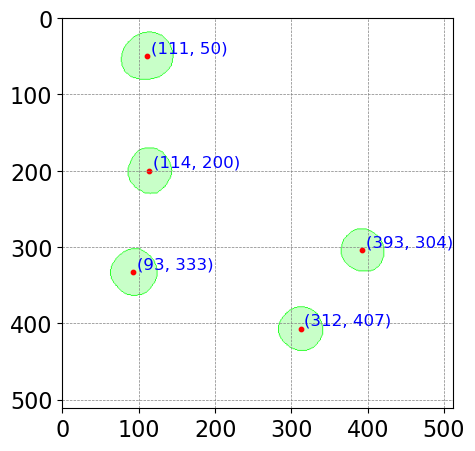

[(312, 407), (93, 333), (393, 304), (114, 200), (111, 50)]

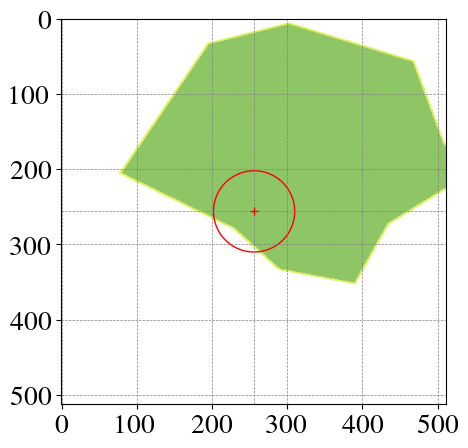

In [107]:
from PIL import ImageDraw

radius=50
image_path = 'media_image_seg2.png' #'../data/2024-11-13-seg-dataset-2048/aug_train/masks/tile_75.png'
mask_path = 'media_image_seg2_mask.png'
#image_path ='media_image_seg.png'
#mask_path = 'media_image_seg_mask.png'

image_path = 'more_in_one.png'
mask_path = 'more_in_one-mask.png'


#mask_path = '02-seg_good-mask.png'

center_x=256
center_y=256
with Image.open(mask_path) as img:
    img = img.convert("L")  # Convert to grayscale
    width, height = img.size
    pixels = np.array(img)
    
    # Create a new image with a white background
    white_background = Image.new("RGB", (width, height), "white")
    white_pixels = (pixels == 255).astype(np.uint8)  # Detect white pixels (polygon area)

    o_white_pixels =[]
    # Draw the edges of the polygon in green
    green_polygon = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(green_polygon)
    for y in range(height):
        for x in range(width):
            if white_pixels[y, x]:
                # Check 8-neighborhood to see if it is an edge pixel
                green_polygon.putpixel((x, y), tuple(int(component * 255) for component in s_color_values[-5][:3]))
                if any(not white_pixels[ny, nx] for nx, ny in [(x-2, y), (x+2, y), (x, y-2), (x, y+2),
                                                               (x-2, y-2), (x+2, y-2), (x-2, y+2), (x+2, y+2)]
                       if 0 <= nx < width and 0 <= ny < height):
                    green_polygon.putpixel((x, y), tuple(int(component * 255) for component in s_color_values[-2][:3]))  # Mark edge as green
                

    #for y in range(center_y - radius, center_y + radius + 1):
    #    for x in range(center_x - radius, center_x + radius + 1):
    #        if (0 <= x < width) and (0 <= y < height):
    #            if ((x - center_x) ** 2 + (y - center_y) ** 2) <= radius ** 2:
    #                if pixels[y, x] == 255:  # White pixel
    #                    o_white_pixels.append((x, y))
                        
    for y in range(center_y, center_y + 1):
        for x in range(center_x, center_x + 1):
            if (0 <= x < width) and (0 <= y < height):
                if pixels[y, x] == 255:  # White pixel
                    o_white_pixels.append((x, y))
fig, ax = plt.subplots(figsize=(5, 5))

# Add grid
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

# Define a circle and add it to the plot
circle = plt.Circle((center_x, center_y), radius+4, color='red', fill=False, linewidth=1)
ax.add_patch(circle)

# Set ticks
ticks = np.arange(0, 513, 100)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# Display the updated image
ax.imshow(green_polygon)

# Add title
#ax.set_title("Polygon Edges in Green on White Background")
if o_white_pixels:
    white_x, white_y = zip(*o_white_pixels)
    ax.scatter(white_x, white_y, s=1, color='lightblue')  # RGBA: Blue with alpha=0.1
ax.axhline(256, color='gray', linewidth=0.5, linestyle="--")
ax.axvline(256, color='gray', linewidth=0.5, linestyle="--")
ax.plot(256,256,'+',color='red')
# Set axis visibility
ax.axis("on")
plt.savefig('../figures/2_seg_method.png', bbox_inches='tight', dpi=600)
# Show the figure
plt.show()


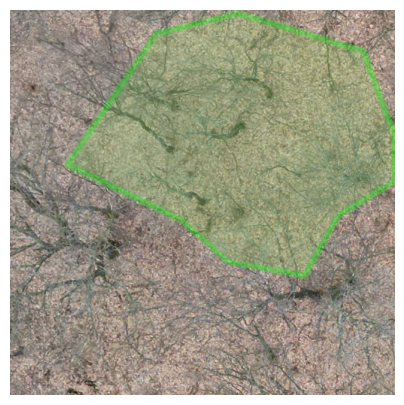

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure
from matplotlib.patches import Polygon

def overlay_filled_polygons_on_image(background, mask, polygon_color=(0, 255, 0), opacity=0.6):
    """
    Overlays filled polygons from a binary mask onto a background image and plots the result.

    Args:
        background (numpy.ndarray): Background image (RGB or grayscale).
        mask (numpy.ndarray): Binary mask (white pixels as polygons, black as background).
        polygon_color (tuple): RGB color for the polygons.
        opacity (float): Opacity of the polygon fill (0 to 1).

    Returns:
        None: Displays the resulting plot with filled polygons overlaid on the background.
    """
    # Ensure the background image is in RGB
    if background.ndim == 2:  # Grayscale to RGB
        background_rgb = np.stack([background] * 3, axis=-1)
    else:
        background_rgb = background.copy()

    # Normalize the polygon color
    polygon_color = np.array(polygon_color) / 255

    # Detect contours from the binary mask
    contours = measure.find_contours(mask, level=0.5)

    # Plot the background
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(background_rgb)

    # Overlay the filled polygons
    for contour in contours:
        contour = np.flip(contour, axis=1)
        polygon = Polygon(contour, closed=True, facecolor=np.array(tuple(int(component * 255) for component in s_color_values[-5][:3])) / 255, edgecolor=polygon_color, alpha=opacity,linewidth=4)
        ax.add_patch(polygon)
        
    plt.savefig('../figures/2_seg_more-in-one.png', bbox_inches='tight', dpi=600)

    # Display the plot
    ax.axis("off")
    plt.show()
    

#np.array((150, 255, 150))
background_image = np.array(Image.open(image_path).convert("RGB"))  # RGB background
mask_image = np.array(Image.open(mask_path).convert("L"))  # Grayscale mask

# Call the function to overlay filled polygons
overlay_filled_polygons_on_image(background_image, mask_image, polygon_color=(0, 255, 0), opacity=0.3)


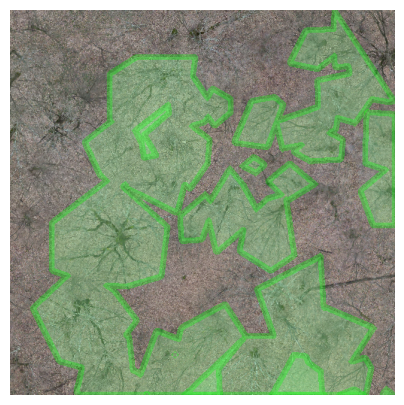

In [63]:
background_image = np.array(Image.open('media_image_seg_2048.png').convert("RGB"))  # RGB background
mask_image = np.array(Image.open('media_image_seg_2048_mask.png').convert("L"))  # Grayscale mask
background_image = np.array(Image.open('media_image_seg_2048_2.png').convert("RGB"))  # RGB background
mask_image = np.array(Image.open('media_image_seg_2048_mask_2.png').convert("L"))  # Grayscale mask
background_image = np.array(Image.open('media_image_seg_2048_3.png').convert("RGB"))  # RGB background
mask_image = np.array(Image.open('media_image_seg_2048_3_mask.png').convert("L"))  # Grayscale mask

# Call the function to overlay filled polygons
overlay_filled_polygons_on_image(background_image, mask_image, polygon_color=(0, 255, 0), opacity=0.3)


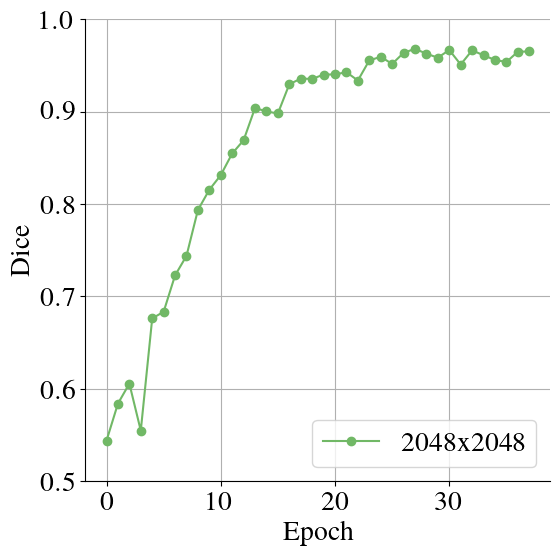

In [86]:
sizes = [2048]
cols = [f'seg-unet-biomed-{size}_sota - Segmentation metrics.Dice' for size in sizes]
rename_mapping = {col: f'{size}x{size}' for col, size in zip(cols, sizes)}

df = pd.read_csv('../figures/wandb_exports/02-seg-overfit_wandb_export_2024-12-11T14_28_54.759+01_00.csv')[cols].rename(columns=rename_mapping)

plt.figure(figsize=(6, 6))
for column in df.columns:
    plt.plot(df.index[:40], df[column][:40], label=column, marker='o', color = s_color_values[4])

plt.yticks(ticks=np.arange(0.5, 1.01, 0.1))
#plt.title('Súlyozott Dice - UNet Biomed')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend(loc="lower right")
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/2_seg_dice_score_overfit.png', bbox_inches='tight', dpi=600)
plt.show()

Note: you may need to restart the kernel to use updated packages.


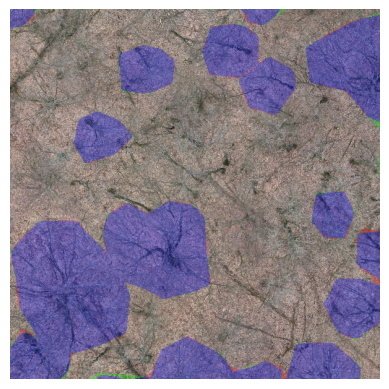

In [102]:
%pip install opencv-python
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2
from models.utils.scores import objectwise_classification_metrics
from PIL import Image

combined_overlay = overlay_combined_mask(
    np.rot90(np.array(Image.open('../figures/2-seg-overfit-image.png'))[:, :, :3]),
    np.rot90((cv2.cvtColor(np.array(Image.open('../figures/2-seg-overfit-mask.png')), cv2.COLOR_RGB2GRAY)==255).astype(int)),
    np.rot90((cv2.cvtColor(np.array(Image.open('../figures/2-seg-overfit-pred.png')), cv2.COLOR_RGB2GRAY)==255).astype(int))
)
plt.imshow(np.rot90(np.rot90(np.rot90(combined_overlay))))

#plt.title('Combined Overlay: True (Green), Pred (Red), Intersection (Blue)')
plt.axis('off')
plt.savefig('../figures/2-seg-overfit.png', bbox_inches='tight', dpi=1200)
plt.show()

In [120]:
pd.read_csv('../figures/wandb_exports/3-seg-dice_wandb_export_2024-12-11T17_55_38.410+01_00.csv').columns

Index(['epoch', 'seg-unet-biomed-2048-ndvi - _step',
       'seg-unet-biomed-2048-ndvi - _step__MIN',
       'seg-unet-biomed-2048-ndvi - _step__MAX',
       'seg-unet-biomed-2048-ndvi - Segmentation metrics.Dice',
       'seg-unet-biomed-2048-ndvi - Segmentation metrics.Dice__MIN',
       'seg-unet-biomed-2048-ndvi - Segmentation metrics.Dice__MAX',
       'seg-unet-biomed-2048-vari - _step',
       'seg-unet-biomed-2048-vari - _step__MIN',
       'seg-unet-biomed-2048-vari - _step__MAX',
       'seg-unet-biomed-2048-vari - Segmentation metrics.Dice',
       'seg-unet-biomed-2048-vari - Segmentation metrics.Dice__MIN',
       'seg-unet-biomed-2048-vari - Segmentation metrics.Dice__MAX',
       'seg-unet-biomed-2048 - _step', 'seg-unet-biomed-2048 - _step__MIN',
       'seg-unet-biomed-2048 - _step__MAX',
       'seg-unet-biomed-2048 - Segmentation metrics.Dice',
       'seg-unet-biomed-2048 - Segmentation metrics.Dice__MIN',
       'seg-unet-biomed-2048 - Segmentation metrics.Dice__MA

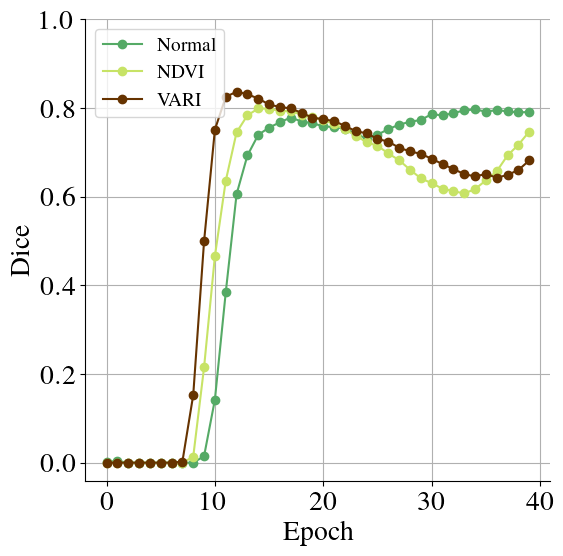

In [38]:
cols = [
    'seg-unet-biomed-2048 - Segmentation metrics.Dice',
    'seg-unet-biomed-2048-ndvi - Segmentation metrics.Dice',
    'seg-unet-biomed-2048-vari - Segmentation metrics.Dice',
]
correct_names = [
    'Normal',
    'NDVI',
    'VARI',
]

bar_colors = [s_color_values[3],s_color_values[-3],b_color_values[0]]
rename_mapping = {col: name for col, name in zip(cols, correct_names)}
df = pd.read_csv('../figures/wandb_exports/3-seg-dice_wandb_export_2024-12-12T19_48_33.511+01_00.csv')[cols].rename(columns=rename_mapping)

plt.figure(figsize=(6, 6))
for index, column in enumerate(df.columns):
    plt.plot(df.index[:40], df[column][:40], label=column, marker='o', color = bar_colors[index])

plt.yticks(ticks=np.arange(0.0, 1.01, 0.2))
#plt.title('Súlyozott Dice - UNet Biomed')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend(loc="upper left", fontsize=14)
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/3_seg_dice_score.png', bbox_inches='tight', dpi=600)
plt.show()

Index(['Step', 'test_biomed_2048-vari - Segmentation metrics.Dice',
       'test_biomed_2048-vari - Segmentation metrics.Dice__MIN',
       'test_biomed_2048-vari - Segmentation metrics.Dice__MAX',
       'test_biomed_2048-ndvi - Segmentation metrics.Dice',
       'test_biomed_2048-ndvi - Segmentation metrics.Dice__MIN',
       'test_biomed_2048-ndvi - Segmentation metrics.Dice__MAX',
       'test_biomed_2048-sota - Segmentation metrics.Dice',
       'test_biomed_2048-sota - Segmentation metrics.Dice__MIN',
       'test_biomed_2048-sota - Segmentation metrics.Dice__MAX'],
      dtype='object')


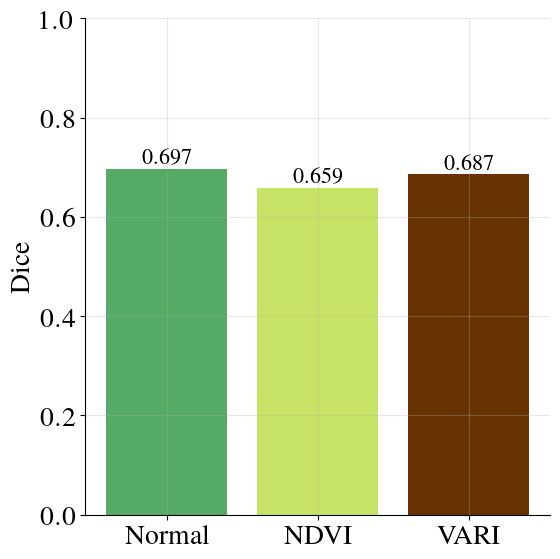

In [34]:
print(pd.read_csv('../figures/wandb_exports/3-seg-dice-test_wandb_export_2024-12-11T17_55_38.410+01_00.csv').columns)

correct_names = [
    'Normal',
    'NDVI',
    'VARI'
]

cols = [
    'test_biomed_2048-sota - Segmentation metrics.Dice',
    'test_biomed_2048-ndvi - Segmentation metrics.Dice',
    'test_biomed_2048-vari - Segmentation metrics.Dice',
    
]
bar_colors = [s_color_values[3],s_color_values[-3],b_color_values[0]]

rename_mapping = {col: name for col, name in zip(cols, correct_names)}

df_combined = pd.read_csv('../figures/wandb_exports/3-seg-dice-test_wandb_export_2024-12-11T17_55_38.410+01_00.csv')[cols].rename(columns=rename_mapping)
df_combined = df_combined.transpose().reset_index().rename(columns={0:'Dice'})
# Plotting
plt.figure(figsize=(6, 6))

plt.bar(df_combined['index'], df_combined['Dice'], label='Dice', color=bar_colors, alpha=1)

for x, y in zip(df_combined['index'], df_combined['Dice']):
    plt.text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=16)

#plt.title('Weighted Recall and Precision by Resolution')
plt.ylabel('Dice')
#plt.xlabel('Képfelbontás')
plt.grid(True, alpha=0.3)
#plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(ticks=np.arange(0.0, 1.1, 0.2))
#plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../figures/3_seg_dice-test_score.png', bbox_inches='tight', dpi=600)
plt.show()


Index(['epoch', 'seg-unet-centroid-2048-sota - _step',
       'seg-unet-centroid-2048-sota - _step__MIN',
       'seg-unet-centroid-2048-sota - _step__MAX',
       'seg-unet-centroid-2048-sota - Segmentation metrics.Dice',
       'seg-unet-centroid-2048-sota - Segmentation metrics.Dice__MIN',
       'seg-unet-centroid-2048-sota - Segmentation metrics.Dice__MAX',
       'seg-taunet-2048-sota - _step', 'seg-taunet-2048-sota - _step__MIN',
       'seg-taunet-2048-sota - _step__MAX',
       'seg-taunet-2048-sota - Segmentation metrics.Dice',
       'seg-taunet-2048-sota - Segmentation metrics.Dice__MIN',
       'seg-taunet-2048-sota - Segmentation metrics.Dice__MAX',
       'seg-unet-biomed-2048 - _step', 'seg-unet-biomed-2048 - _step__MIN',
       'seg-unet-biomed-2048 - _step__MAX',
       'seg-unet-biomed-2048 - Segmentation metrics.Dice',
       'seg-unet-biomed-2048 - Segmentation metrics.Dice__MIN',
       'seg-unet-biomed-2048 - Segmentation metrics.Dice__MAX',
       'ds_transunet_

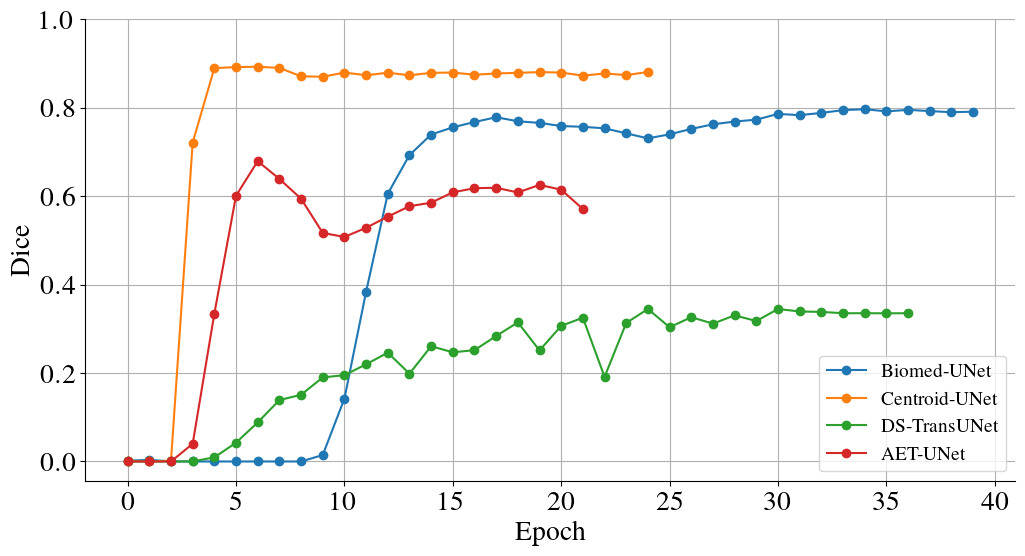

In [24]:
print(pd.read_csv('../figures/wandb_exports/4-seg-dice_wandb_export_2024-12-13T09_12_59.222+01_00.csv').columns)

cols = [
    'seg-unet-biomed-2048 - Segmentation metrics.Dice',
    'seg-unet-centroid-2048-sota - Segmentation metrics.Dice',
    'ds_transunet_seg_base_512_u10_sota - Segmentation metrics.Dice',
    'seg-taunet-2048-sota - Segmentation metrics.Dice',
]
correct_names = [
    'Biomed-UNet',
    'Centroid-UNet',
    'DS-TransUNet',
    'AET-UNet',
    #'YOLOv11-seg',
]


rename_mapping = {col: name for col, name in zip(cols, correct_names)}
df = pd.read_csv('../figures/wandb_exports/4-seg-dice_wandb_export_2024-12-13T09_12_59.222+01_00.csv')[cols].rename(columns=rename_mapping)

plt.figure(figsize=(12, 6))
for column in df.columns:
    plt.plot(df.index[:40], df[column][:40], label=column, marker='o')

plt.yticks(ticks=np.arange(0, 1.01, 0.2))
#plt.title('Súlyozott Dice - UNet Biomed')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../figures/4_seg_dice_score.png', bbox_inches='tight', dpi=600)
plt.show()

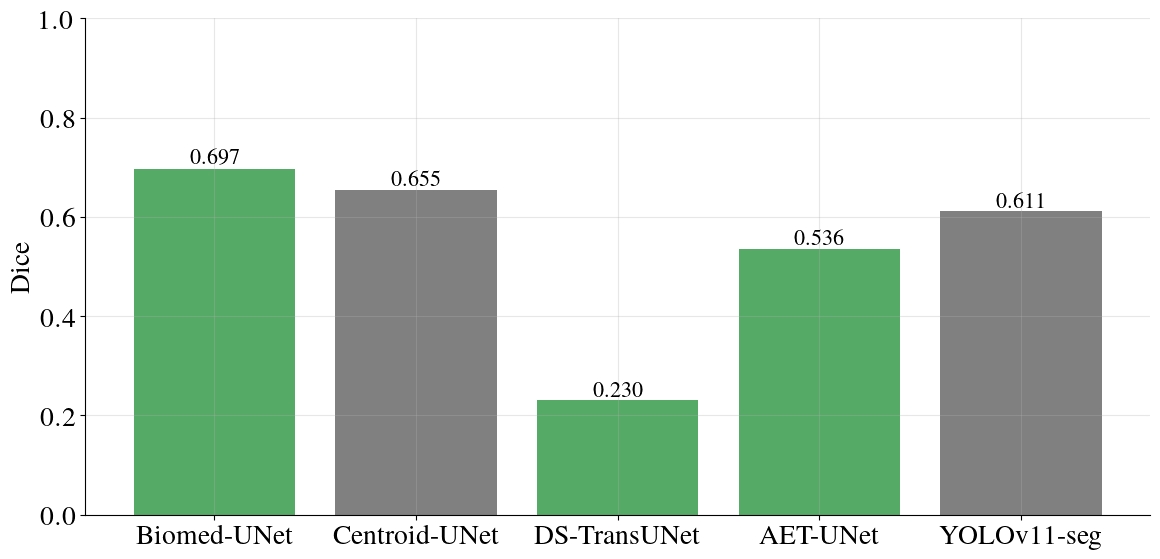

In [40]:
correct_names = [
    'Biomed-UNet',
    'Centroid-UNet',
    'DS-TransUNet',
    'AET-UNet',
    'YOLOv11-seg',
]

cols = [
    'test_biomed_2048-sota - Segmentation metrics.Dice',
    'test_centroid_2048 - Segmentation metrics.Dice',
    'ds_transunet_seg_base_512_u10_sota - Segmentation metrics.Dice',
    'test_taunet_2048 - Segmentation metrics.Dice',
    'test_yolo_seg_512 - Segmentation metrics.Dice',
]

rename_mapping = {col: name for col, name in zip(cols, correct_names)}

df_combined = pd.read_csv(
    '../figures/wandb_exports/04-seg-dice-test_wandb_export_2024-12-13T09_56_39.438+01_00.csv'
)[cols].rename(columns=rename_mapping)
df_combined = df_combined.transpose().reset_index().rename(columns={0: 'Dice'})

# Define colors for the bars
bar_colors = []
for method in df_combined['index']:
    if method in ['Centroid-UNet', 'YOLOv11-seg']:
        bar_colors.append('gray')  # Assign gray color to specific methods
    else:
        bar_colors.append(s_color_values[3])  # Use your desired color for others

# Plotting
plt.figure(figsize=(12, 6))

plt.bar(df_combined['index'], df_combined['Dice'], color=bar_colors, alpha=1)

for x, y in zip(df_combined['index'], df_combined['Dice']):
    plt.text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=16)

plt.ylabel('Dice')
plt.grid(True, alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(ticks=np.arange(0.0, 1.1, 0.2))
plt.tight_layout()
plt.savefig('../figures/4_seg_dice-test_score.png', bbox_inches='tight', dpi=600)
plt.show()


torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


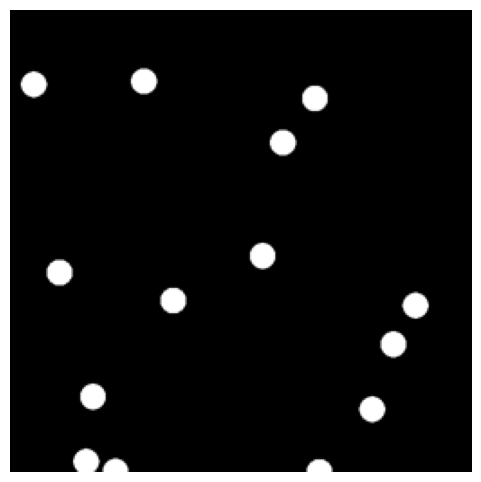

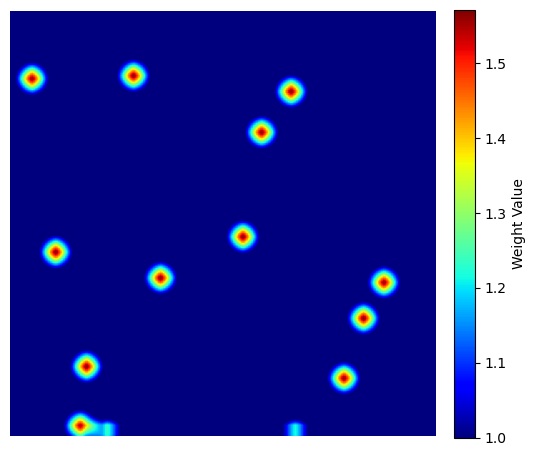

In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the mask from a PNG file
image_path = "../data/2024-10-30-loc-dataset-1024/u_aug_train_u10/masks/tile_shp_14_10.png"  # Replace with the actual file path
mask_image = Image.open(image_path).convert("L")  # Convert to grayscale

# Resize the image to 256x256 if it's not already
mask_image = mask_image.resize((256, 256))
mask_array = np.array(mask_image, dtype=np.float32)  
# Convert the image to a PyTorch tensor and normalize the values to [0, 1]
mask = torch.tensor(mask_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

print(mask.size())

# Calculate the weight map
weit = 1 + F.avg_pool2d(mask, kernel_size=13, stride=1, padding=6) / 255.0
weit = torch.where(weit < 1.2, torch.tensor(1.0, dtype=weit.dtype, device=weit.device), weit / 1.2)
print(weit.size())

# Convert tensors to numpy for visualization
mask_np = mask[0, 0].numpy()
weit_np = weit[0, 0].numpy()

# Plot the original mask
plt.figure(figsize=(6, 6))
im1 = plt.imshow(mask_np, cmap='gray')
#plt.colorbar(im1, fraction=0.046, pad=0.04).set_label('Intensity')
#plt.title("Original Mask")
plt.axis('off')
plt.show()

# Plot the weight map
plt.figure(figsize=(6, 6))
im2 = plt.imshow(weit_np, cmap='jet')
plt.colorbar(im2, fraction=0.046, pad=0.04).set_label('Weight Value')
#plt.title("Weight Map")
plt.axis('off')
plt.show()


Note: you may need to restart the kernel to use updated packages.


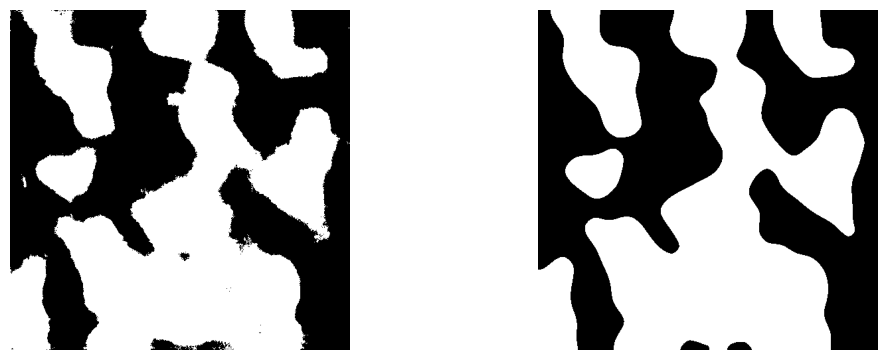

In [42]:
# Re-import necessary libraries and reinitialize the code for the median filter and visualization
%pip install opencv-python
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from PIL import Image
import cv2

# Load an example image
image_path = 'media_images_pred_319_7a03f30a74f1a337175b.png'  # Replace with your image path seg-noise.png
image_path = 'seg-noise.png'  # Replace with your image path 
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Convert the image to a NumPy array
image_array = np.array(image)
# Apply a median filter
filtered_image = median_filter(image_array, size=5)
filtered_image = median_filter(filtered_image, size=15)
filtered_image = median_filter(filtered_image, size=25)
cv2.imwrite('filtered_image.png', filtered_image)
# Plot the original, noisy, and filtered images
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
#plt.title("Predicted Mask")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
#plt.title("Median filtered Mask")
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.savefig('../figures/5_seg_filter.png', bbox_inches='tight', dpi=600)
plt.show()


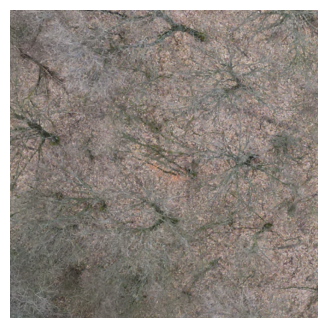

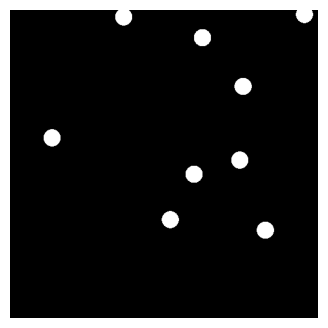

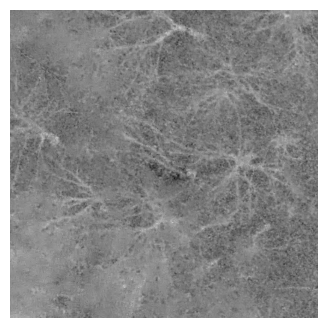

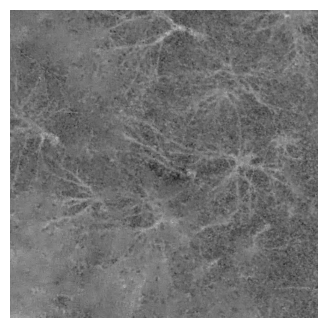

In [38]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.color import label2rgb
import matplotlib.pyplot as plt

def shadow_boosting_with_slic(image):
    image = shadow_boosting(image)

    image = cv2.GaussianBlur(image, (7, 7), 0)
    image = cv2.medianBlur(image, 3)
    image = cv2.GaussianBlur(image, (7, 7), 0)
    image = cv2.medianBlur(image, 3)
    image = cv2.GaussianBlur(image, (7, 7), 0)
    image = cv2.medianBlur(image, 3)

    n_segments = 1000
    compactness = 10
    superpixels = slic(image, n_segments=n_segments, compactness=compactness, start_label=1)
    return label2rgb(superpixels, image, kind='avg')

def shadow_boosting(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(image.shape) == 3:
        return cv2.merge([clahe.apply(channel) for channel in cv2.split(image)])
    else:
        return clahe.apply(image)  # Grayscale

def NDVI(image):
    green = image[:, :, 1].astype(float)
    red = image[:, :, 2].astype(float)

    # Calculate NDVI
    ndvi = (green - red) / (green + red + 1e-5)  # Adding small value to avoid division by zero

    return cv2.normalize(ndvi, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def VARI(image):
    blue = image[:, :, 0].astype(float)
    green = image[:, :, 1].astype(float)
    red = image[:, :, 2].astype(float)

    # Calculate VARI
    vari = (green - red) / (green + red - blue + 1e-5)  # Adding small value to avoid division by zero

    return cv2.normalize(vari, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Load an example image
image = cv2.imread("../data/2024-10-30-loc-dataset-1024/u_aug_train_u10/images/tile_tif_7_5.png")

# Original Image
plt.figure(figsize=(4,4))
#plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Mask Image
mask_image = cv2.imread("../data/2024-10-30-loc-dataset-1024/u_aug_train_u10/masks/tile_shp_7_5.png")
plt.figure(figsize=(4,4))
#plt.title("Mask Image")
plt.imshow(cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# NDVI Image
ndvi_image = NDVI(image)
plt.figure(figsize=(4,4))
#plt.title("NDVI")
plt.imshow(ndvi_image, cmap='gray')
plt.axis("off")
plt.show()

# VARI Image
vari_image = VARI(image)
plt.figure(figsize=(4, 4))
#plt.title("VARI")
plt.imshow(vari_image, cmap='gray')
plt.axis("off")
plt.show()


In [3]:
model = UNet.model(UNet.config(n_channels=3, n_classes=1, bilinear=False))
load_model(
    model,
    './legacy/checkpoints_seg-unet-biomed-2048_2024-11-16_07-56_sota_checkpoint_epoch37.pth',#'./legacy/checkpoints_loc-unet-centroid-1024_2024-11-20_11-01_sota_checkpoint_epoch26.pth',
    'cpu'
)

index = '1375'

full_img = Image.open(f'../data/2024-11-13-seg-dataset-2048/u_test/images/tile_{index}.png')
true_mask = Image.open(f'../data/2024-11-13-seg-dataset-2048/u_test/masks/tile_{index}.png')
pred = predict_img(
    net = model,
    full_img = full_img,
    device = 'cpu',
    scale_factor=1,
    out_threshold=0.5
)

print(np.array(true_mask).shape)

mask_true = (torch.tensor(np.array(true_mask)).unsqueeze(0) == 255).int()
mask_pred = torch.tensor(pred).unsqueeze(0)

true_mask = np.squeeze(mask_true.squeeze(0).numpy())
pred_mask = np.squeeze(mask_pred.squeeze(0).numpy())

#true_mask =np.rot90(true_mask)
#pred_mask =np.rot90(pred_mask)
plt.figure(figsize=(8, 8))
combined_overlay = overlay_combined_mask(np.array(Image.open(f'../data/2024-11-13-seg-dataset-2048/u_test/images/tile_{index}.png')), true_mask, pred_mask)
plt.imshow(combined_overlay)
#plt.title('Combined Overlay: True (Green), Pred (Red), Intersection (Blue)')
plt.axis('off')
plt.show()

NameError: name 'UNet' is not defined

   id                            geometry
0 NaN  MULTIPOINT (549326.572 221091.039)
1 NaN  MULTIPOINT (549326.695 221089.804)
2 NaN  MULTIPOINT (549330.773 221089.208)
3 NaN  MULTIPOINT (549334.999 221092.036)
4 NaN  MULTIPOINT (549335.169 221073.629)
EPSG:23700


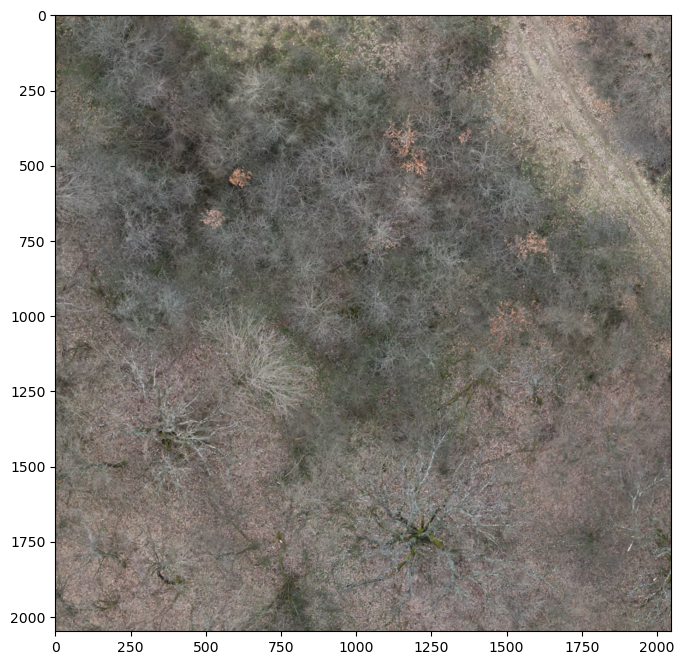

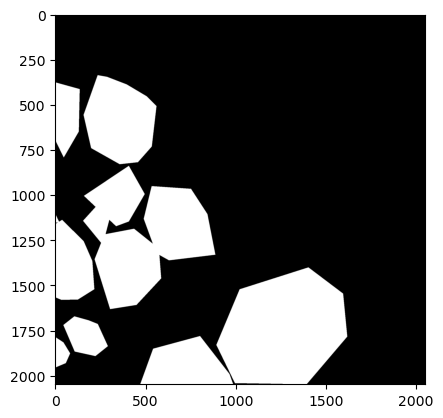

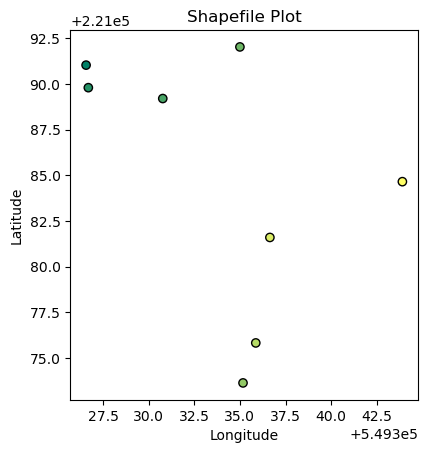

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image

# Path to your shapefile

shapefile_path = '../data/2024-12-08-seg2-dataset-2048/all/original/shps/tile_shp_3_5.shp'  # Replace with your .shp file path
shapefile_path = '../data/2024-10-30-loc-dataset-1024/all/original/shps/tile_shp_17_13.shp'  # Replace with your .shp file path

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Print basic information about the shapefile
print(gdf.head())  # Displays the first few rows
print(gdf.crs)  # Displays the coordinate reference system (CRS)

# Plot the shapefile
plt.figure(figsize=(10, 8))
#plt.imshow(Image.open(f'../data/2024-12-08-seg2-dataset-2048/all/original/tifs/tile_tif_3_5.tif'))
plt.imshow(Image.open(f'../data/2024-12-08-seg2-dataset-2048/all/formatted/images/tile_tif_3_5.png'))
plt.show()

plt.imshow(Image.open(f'../data/2024-12-08-seg2-dataset-2048/all/formatted/masks/tile_shp_3_5.png'))
gdf.plot(edgecolor="black", column=None, cmap='summer', legend=True)  # Customize the style
plt.title("Shapefile Plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
